<h1 align='center'>
Sberbank Data Science Contest 2017: Problem A
</h1>
<img align="right" src="img/task_a.png" width=400px; height=400px>
<h4 align='right'>
Автор решения: Александр Желубенков (topspin26), 1 место.
</h4>
</h1>

<h2 align='center'>Model Training</h2>

## Этапы решения 5-6


(В другой тетрадке)

* Этап 0. Чтение и подготовка данных
* Этап 1. Построение факторов для вопроса
* Этап 2. Исправление опечаток в вопросе
* Этап 3. Построение факторов для пары параграф-вопрос
* Этап 4. Построение факторов для параграфа


* [Этап 5. Обучение моделей](#Этап-5.-Обучение-моделей)
 * [ Получение полного набора признаков](#Получение-полного-набора-признаков)
 * [Разбиение выборки для кросс-валидации](#Разбиение-выборки-для-кросс-валидации)
 * [Отбор признаков](#Отбор-признаков)
 * [Обучение модели 1](#Обучение-модели-1)
 * [Обучение модели 2](#Обучение-модели-2)
 * [Получение финальных предсказаний](#Получение-финальных-предсказаний)
<div style='margin:10px'></div>
* [Этап 6. Анализ предсказаний](#Этап-6.-Анализ-предсказаний)

In [142]:
%load_ext autoreload
%autoreload 2

import sys
print(sys.version)
import os
import random
import json
import re
import pandas as pd
import numpy as np
import scipy as sp
import scipy.sparse as sps
from sklearn import metrics
from sklearn.cluster import SpectralClustering
import math
import seaborn as sns
import nltk
import zlib
from collections import Counter
import xgboost as xgb
from Levenshtein import distance

import tqdm
from tqdm import tqdm_notebook

from IPython.display import display

import matplotlib as mpl
import matplotlib.patches as patches
get_ipython().magic('matplotlib inline')
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import HTML

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_colwidth', -1)

display(HTML(data="""
<style>
    div#notebook-container    { width: 80%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 79%; }
</style>
"""))

sns.set(font_scale = 1.2)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
3.5.4 |Anaconda, Inc.| (default, Sep 30 2017, 11:07:29) [MSC v.1900 64 bit (AMD64)]


In [2]:
import common_ml

## Этап 5. Обучение моделей

Обучать будем две модели(xgb):
1. для отделения единичек (положительных примеров из train выборки) от всего остального (т.е. нулей из train и всей test выборки),<br> **цель - научиться отделять релевантные пары (параграф, вопрос) от нерелевантных пар и пар с синтетическими вопросами**;
2. для отделения train выборки от всей test выборки,<br> **цель - научиться отделять нормальные пары(с человеческими вопросами) от пар с синтетическими вопросами**;

Т.е. намеренно обучаем обе модели на зашумленной разметке, т.к. пары из тестовой выборки при обучении используются в качестве негативных примеров. <br>
Для получения предсказаний обеих моделей на test выборке делаем это с разбиением test-а на 5 фолдов (при этом обучаем модели 1) и 2) без того фолда, на котором хотим получить предсказания).<br>
**Финальное предсказание - произведение выходов из моделей 1) и 2).**

### Получение полного набора признаков

Итак, все вычисленные факторы для вопросов и для пар (параграф-вопрос) были сохранены в файлы, поэтому для возможности оперативного запуска сразу с данного этапа, загрузим факторы из файлов.

In [3]:
df_all_questions = pd.read_csv('data/df/df_all_questions.txt', sep='\t', encoding='utf-8', index_col=0)
assert df_all_questions.shape == (82211, 1724)

In [4]:
df_all_questions.columns

Index(['question', 'question_ms', 'question_ms_upper', 'question_id', 'isTr',
       'qCnt', 'isTr1', 'question_pos', 'question_pr_s_case',
       'question_a_s_case',
       ...
       'paragraph_pr_s_case_score_min', 'paragraph_a_s_case_score_mean',
       'paragraph_a_s_case_score_min', 'paragraph_a_v_s_CH_score_mean',
       'paragraph_a_v_s_CH_score_min', 'paragraph_a_v_s_R_score_mean',
       'paragraph_a_v_s_R_score_min', 'paragraph_a_v_s_OTH_score_mean',
       'paragraph_a_v_s_OTH_score_min', 'cntSpell'],
      dtype='object', length=1724)

In [5]:
df_all = pd.read_csv('data/df/df_all.txt', sep='\t', encoding='utf-8', index_col=0)
assert df_all.shape == (193684, 56)

In [6]:
df_all.columns

Index(['paragraph', 'paragraph_id', 'question', 'question_id', 'target',
       'isTr', 'question_ms', 'question_ms_upper', 'question_ms_S',
       'question_ms_SAV', 'paragraph_ms', 'paragraph_ms_upper',
       'paragraph_ms_S', 'paragraph_ms_SAV', 'sim4_pq_3chars', 'sim4_pq',
       'sim4_pq_split', 'sim4_pq_split_w', 'sim5_pq', 'sim_final',
       'sim4_pq_split_S', 'myScore_S_pq', 'myScore_S_pq_minimax',
       'myScore_AV_pq_minimax', 'w2vScore_qp_min', 'w2vScore_qp_minimax',
       'qp_lcs', 'qp_lcs2', 'qp_lcs_rel', 'qp_lcs2_rel', 'qrank_for_p',
       'qrank1_for_p', 'prank_for_q', 'qp_rank_score', 'e_qsim', 'disp_qsim',
       'len_qsim', 'min_qrank', 'max_qsim', 'max2_qsim', 'max5_qsim',
       'max10_qsim', 'max20_qsim', 'qp_rank_score_sim', 'lastWord1',
       'lastWord1_PR', 'lastWord2', 'lastWord2_PR', 'lastWord1_score',
       'lastWord1_PR_score', 'lastWord2_score', 'lastWord2_PR_score', 'qWord3',
       'qWord2', 'qWord3_score', 'qWord2_score'],
      dtype='object')

**Склеим факторы вопросов с факторами для пар параграф-вопрос**

In [7]:
dfp = df_all.merge(df_all_questions[list(df_all_questions.columns)[3:]], on=['question_id', 'isTr'])
dfp.shape, df_all.shape

((193684, 1775), (193684, 56))

Отметим существенное отличие числа вопросов к одному параграфу для тренировочной и тестовой выборки:
* для тренировочной выборки топ-10 наиболее популярных значений числа вопросов на один параграф - от 1 до 10;
* для тестовой выборки топ-10 наиболее популярных значений существенно больше - 24+

In [8]:
display(df_all[df_all.isTr == 1][['question', 'paragraph']].groupby('paragraph').\
        agg(len).reset_index()['question'].value_counts().reset_index().head(10).transpose())
display(df_all[df_all.isTr == 0][['question', 'paragraph']].groupby('paragraph').\
        agg(len).reset_index()['question'].value_counts().reset_index().head(10).transpose())

,0,1,2,3,4,5,6,7,8,9
index,4,5,2,1,3,9,10,6,8,7
question,1505,1461,1369,1301,1295,275,263,162,145,125


,0,1,2,3,4,5,6,7,8,9
index,30,26,25,27,24,34,29,28,31,32
question,82,82,69,61,55,52,52,47,44,42


**Важно**: из-за того что модели будут обучаться на зашумленной разметке (пары из тестовой выборки используются в качестве негативных примеров), при добавлении в качестве фактора параграфа "числа вопросов на один параграф", тестовая выборка будет легко отделяться от тренировочной на основании данного фактора.

Однако пользы от такого разделения НЕ будет, а будет только вред, т.к. будут найдены закономерности, не согласующиеся с цельями обучения моделей:
* научиться отделять релевантные пары (параграф, вопрос) от нерелевантных пар и пар с синтетическими вопросами;
* научиться отделять нормальные пары от пар с синтетическими вопросами;

**1708 факторов для вопроса**

In [9]:
q_features = [e for e in list(df_all_questions.columns[13:]) if e not in {'question_wo_A', 'lt', 'lt_wo_A'}]

In [10]:
print(len(q_features))

1708


**36 факторов для пары (параграф-вопрос)**

In [11]:
qp_features = list(df_all.columns[14:44]) + list(df_all.columns[48:52]) + list(df_all.columns[54:])

In [12]:
print(len(qp_features))
print(qp_features)

36
['sim4_pq_3chars', 'sim4_pq', 'sim4_pq_split', 'sim4_pq_split_w', 'sim5_pq', 'sim_final', 'sim4_pq_split_S', 'myScore_S_pq', 'myScore_S_pq_minimax', 'myScore_AV_pq_minimax', 'w2vScore_qp_min', 'w2vScore_qp_minimax', 'qp_lcs', 'qp_lcs2', 'qp_lcs_rel', 'qp_lcs2_rel', 'qrank_for_p', 'qrank1_for_p', 'prank_for_q', 'qp_rank_score', 'e_qsim', 'disp_qsim', 'len_qsim', 'min_qrank', 'max_qsim', 'max2_qsim', 'max5_qsim', 'max10_qsim', 'max20_qsim', 'qp_rank_score_sim', 'lastWord1_score', 'lastWord1_PR_score', 'lastWord2_score', 'lastWord2_PR_score', 'qWord3_score', 'qWord2_score']


In [13]:
df_all[qp_features].head().transpose()

,0,1,2,3,4
sim4_pq_3chars,2.383953e-01,7.620362e-02,1.914449e-01,1.849030e-01,0.661793
sim4_pq,1.813501e-01,6.344555e-02,2.105257e-01,2.725061e-02,0.711413
sim4_pq_split,1.124681e-01,3.088522e-02,2.028645e-01,2.725061e-02,0.711413
sim4_pq_split_w,1.124681e-01,4.780000e-02,2.028645e-01,2.725061e-02,0.711413
sim5_pq,2.479180e-01,1.359171e-01,2.702006e-01,2.118364e-01,0.711413
sim_final,1.793519e-01,5.984959e-02,2.014756e-01,1.074235e-01,0.689084
sim4_pq_split_S,3.179896e-03,2.056494e-03,1.074763e-01,3.753191e-03,0.586721
myScore_S_pq,3.248637e-04,7.770066e-04,3.894530e-04,4.286620e-04,0.000652
myScore_S_pq_minimax,8.111071e-02,8.688226e-02,9.182997e-02,7.216878e-02,0.202908
myScore_AV_pq_minimax,1.386750e-01,9.901475e-02,1.035337e-01,1.209449e-01,0.999713


**Полный набор признаков**

In [14]:
features_full = q_features + qp_features
print(len(features_full))

1744


### Разбиение выборки для кросс-валидации

Тестовая и тренировочная выборки по параграфам НЕ пересекаются:

In [15]:
df_all.paragraph.nunique(), df_all[df_all.isTr == 1].paragraph.nunique(), df_all[df_all.isTr == 0].paragraph.nunique()

(10705, 9078, 1627)

Разбивать пары на группы будем на основании параграфов, причем разбивать будем обе выборки (train и test), т.к. это пригодится далее.

In [16]:
from random import shuffle
kf_suff = ['_0', '_1', '_2', '_3', '_4']
for j, myseed in enumerate([239, 777, 26, 17, 101]):
    random.seed(myseed)
    nFold = 5
    allp_train = list(sorted(set(dfp[dfp.isTr == 1].paragraph)))
    ntr = len(allp_train)
    allp_test = list(sorted(set(dfp[dfp.isTr == 0].paragraph)))
    nte = len(allp_test)
    shuffle(allp_train)
    shuffle(allp_test)
    print(ntr, nte)
    allp2kf = dict()
    for i,p in enumerate(allp_train):
        allp2kf[p] = i % nFold
    for i,p in enumerate(allp_test):
        allp2kf[p] = i % nFold
    dfp['p_kf' + kf_suff[j]] = dfp.paragraph.map(allp2kf)
    print(dfp['p_kf' + kf_suff[j]].value_counts())

9078 1627
3    41891
0    39460
4    39078
2    38597
1    34658
Name: p_kf_0, dtype: int64
9078 1627
3    44374
1    42090
4    36627
0    35789
2    34804
Name: p_kf_1, dtype: int64
9078 1627
3    42691
0    40819
1    38583
2    36133
4    35458
Name: p_kf_2, dtype: int64
9078 1627
3    46323
4    42405
0    38289
1    33398
2    33269
Name: p_kf_3, dtype: int64
9078 1627
2    42357
0    41038
3    39155
1    38334
4    32800
Name: p_kf_4, dtype: int64


Для модели 2 (целью обучения которой является научиться отделять нормальные пары от пар с синтетическими вопросами), используем тот факт, что **синтетические вопросы НЕ могут повторяться**.<br>
Для пар с такими вопросами в качестве целевой переменной проставим единички (т.к. это явно положительные примеры).

In [17]:
dfp['p_target1'] = (dfp.target == 1).astype(int)
dfp['p_target01'] = (dfp.isTr == 1).astype(int)
dfp.loc[dfp.qCnt > 1, 'p_target01'] = 1

### Отбор признаков

Всего было сгенерировано 1744 факторов для пар (параграф-вопрос), однако большинство из них - это вопросные факторы, причем достаточно слабые.

Для того чтобы убрать явно бесполезные факторы, обучим обе модели на полном наборе факторов и оставим для каждой модели только те из них, которые хотя бы раз использовались при разбиении в вершинах деревьев.

**Модель 1**

In [18]:
xgb_params_0 = {'max_depth': 5,
              'min_child_weight': 30,
              'n_estimators': 80,
              'learning_rate': 0.4,
              'colsample_bylevel':  0.1,
              'silent': False,
              'seed': 1}
model1 = xgb.XGBClassifier(**xgb_params_0)
model1.fit(dfp[features_full + ['qCnt']], dfp['p_target1'])

XGBClassifier(base_score=0.5, colsample_bylevel=0.1, colsample_bytree=1,
       gamma=0, learning_rate=0.4, max_delta_step=0, max_depth=5,
       min_child_weight=30, missing=None, n_estimators=80, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=1, silent=False, subsample=1)

Посмотрим на важнейшие признаки(по двум типам важности - *weight* и *gain*) и сохраним в файл признаки, которые используются в модели

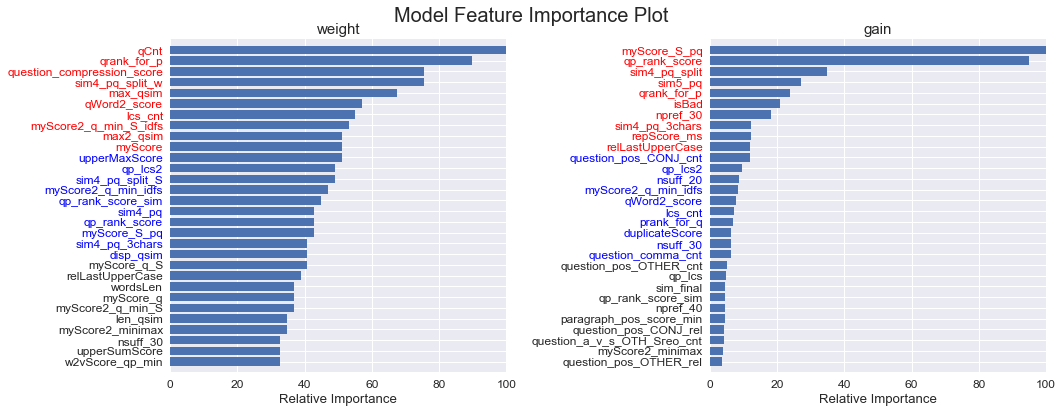

265


,feature,importance
1715,myScore_S_pq,100.000000
1727,qp_rank_score,94.821300
1710,sim4_pq_split,34.824052
1712,sim5_pq,27.094998
1724,qrank_for_p,23.936112


In [218]:
common_ml.drawFeaturesImportancePlot2(common_ml.getFeaturesImportance1(model1._Booster.feature_names, model1, importance_type='weight'),
                                      common_ml.getFeaturesImportance1(model1._Booster.feature_names, model1, importance_type='gain'), 30,
                                      names=['weight', 'gain'])

features_model_1 = common_ml.getFeaturesImportance1(model1._Booster.feature_names, model1, importance_type='gain')
nf = sum(features_model_1.importance > 0)
print(nf)
features_model_1 = features_model_1[:nf]


if not os.path.exists('data/features'):
    os.mkdir('data/features')
        
with open('data/features/features_model_1_new.txt', 'w', encoding='utf-8') as fout:
    for e1, e2 in zip(features_model_1.feature, features_model_1.importance):
        fout.write(e1 + '\t' + str(e2) + '\n')
display(features_model_1.head())
features_model_1 = features_model_1.feature.values

Видим, что из 1745 факторов(1744 + qCnt) в 80 деревьях с максимальной глубиной 5, используются только 265 из них.<br>
Причем модель использует все факторы для пары (параграф-вопрос), за исключением одного

In [23]:
print(len(features_model_1))
set(qp_features) - set(features_model_1)

265


{'lastWord1_score'}

**Модель 2** (так сложилось, что в коде для нее был выбран суффикс 01)

В отличие от модели 1, здесь мы НЕ будем добавлять фактор *qCnt*, т.к. он напрямую связан с целевой переменной (если *qCnt*>1, то *p_target01*=1)

In [22]:
model01 = xgb.XGBClassifier(**xgb_params_0)
model01.fit(dfp[features_full], dfp['p_target01'])

XGBClassifier(base_score=0.5, colsample_bylevel=0.1, colsample_bytree=1,
       gamma=0, learning_rate=0.4, max_delta_step=0, max_depth=5,
       min_child_weight=30, missing=None, n_estimators=80, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=1, silent=False, subsample=1)

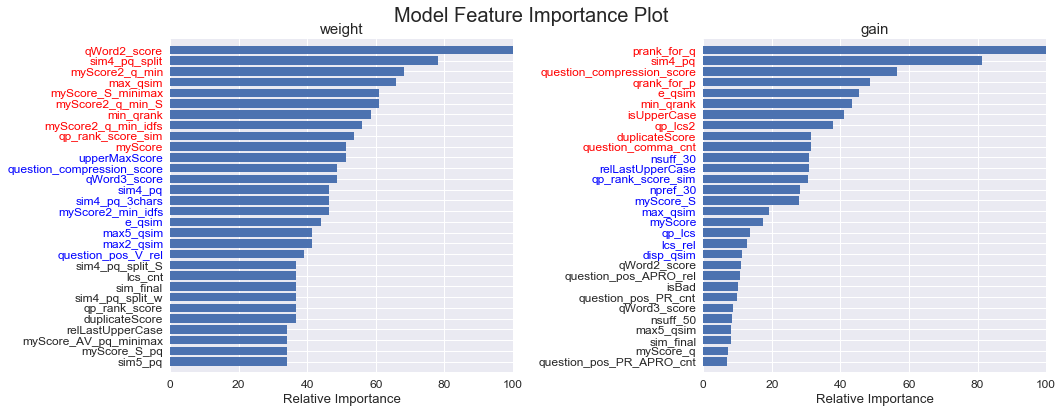

254


,feature,importance
1726,prank_for_q,100.000000
1709,sim4_pq,81.372243
1484,question_compression_score,56.426651
1724,qrank_for_p,48.485976
1728,e_qsim,45.502724
1731,min_qrank,43.406411
1485,isUpperCase,41.013587
1721,qp_lcs2,37.743687
1491,duplicateScore,31.402875
1494,question_comma_cnt,31.368862


In [217]:
common_ml.drawFeaturesImportancePlot2(common_ml.getFeaturesImportance1(model01._Booster.feature_names, model01, importance_type='weight'),
                                      common_ml.getFeaturesImportance1(model01._Booster.feature_names, model01, importance_type='gain'), 30,
                                      names=['weight', 'gain'])

features_model_01 = common_ml.getFeaturesImportance1(model01._Booster.feature_names, model01, importance_type='gain')
nf = sum(features_model_01.importance > 0)
print(nf)
features_model_01 = features_model_01[:nf]


if not os.path.exists('data/features'):
    os.mkdir('data/features')
        
with open('data/features/features_model_01_new.txt', 'w', encoding='utf-8') as fout:
    for e1, e2 in zip(features_model_01.feature, features_model_01.importance):
        fout.write(e1 + '\t' + str(e2) + '\n')
display(features_model_01.head(10))
features_model_01 = features_model_01.feature.values

Видим, что из 1744 факторов в 80 деревьях с максимальной глубиной 5, используются только 254 из них.<br>
Причем модель использует все факторы для пары (параграф-вопрос), за исключением двух

In [25]:
print(len(features_model_01))
set(qp_features) - set(features_model_01)

254


{'qrank1_for_p'}

**Отбор вопросных признаков был произведен до того, как был сформирован итоговый полный набор факторов**

Результаты первого отбора были сохранены в файлы и использовались при обучении итоговых моделей.

Т.к. при выборе разбиений в xgboost используется random, а набор факторов для первого отбора отличался от полного набора факторов, при текущем воспроизводимом отборе, отбираются другие слабые вопросные факторы (при этом их количество остается прежним ~250 факторов)

In [ ]:
#features_model_1_new = features_model_1

In [26]:
features_model_1 = []
with open('data/features/features_model_1.txt', encoding='utf-8') as fin:
    for line in fin:
        tokens = line.rstrip().split('\t')
        features_model_1.append(tokens[0])

In [ ]:
#print(len(set(features_model_1) - set(features_model_1_new)), (len(set(features_model_1_new) - set(features_model_1))))

In [ ]:
#features_model_01_new = features_model_01

In [27]:
features_model_01 = []
with open('data/features/features_model_01.txt', encoding='utf-8') as fin:
    for line in fin:
        tokens = line.rstrip().split('\t')
        features_model_01.append(tokens[0])

In [ ]:
#print(len(set(features_model_01) - set(features_model_01_new)), (len(set(features_model_01_new) - set(features_model_01))))

** Сформируем итоговые наборы фаткоров для обеих моделей**

In [28]:
qp_features_final = ['sim4_pq', 'sim4_pq_split', 'sim4_pq_3chars', 'sim4_pq_split_w', 'sim5_pq', 'sim_final', 'sim4_pq_split_S']
qp_features_final += ['myScore_S_pq', 'myScore_S_pq_minimax', 'myScore_AV_pq_minimax']
qp_features_final += ['qp_lcs', 'qp_lcs_rel', 'qp_lcs2', 'qp_lcs2_rel']
qp_features_final += ['qrank_for_p', 'qrank1_for_p', 'prank_for_q', 'e_qsim',
                      'disp_qsim', 'len_qsim', 'qp_rank_score', 'min_qrank', 'max_qsim',
                      'max2_qsim', 'max5_qsim', 'max10_qsim', 'max20_qsim', 'qp_rank_score_sim']

In [29]:
qnew_features = []
for f in ['paragraph_pos', 'paragraph_pr_s_case', 'paragraph_a_s_case', 'paragraph_a_v_s_CH', 'paragraph_a_v_s_R', 'paragraph_a_v_s_OTH']:
        qnew_features += [f + '_score_mean', f + '_score_min']
qnew_features += ['myScore2_q_min']
qnew_features += ['qWord3_score', 'qWord2_score']
qnew_features += ['w2vScore_qp_minimax']

In [30]:
final_features_model1 = list(features_model_1)
final_features_model1 += [e for e in qp_features_final if e not in final_features_model1]
final_features_model1 += [e for e in qnew_features if e not in final_features_model1]

** В итоговой первой модели используется 329 факторов**

In [31]:
len(final_features_model1)

329

Выведем неиспользованные в итоговой модели 1 факторы для пар (параграф-вопрос)

In [32]:
set(qp_features) - set(final_features_model1)

{'lastWord1_PR_score',
 'lastWord1_score',
 'lastWord2_PR_score',
 'lastWord2_score',
 'w2vScore_qp_min'}

Выведем также неиспользованные в итоговой модели 1 факторы вопроса (за исключением групп факторов с большим числом редких слабых факторов)

In [33]:
for e in sorted(set(q_features) - set(final_features_model1)):
    if e.startswith('lt_') or e.startswith('question_a_v_s_R_') or e.startswith('question_pos_') or\
       e.startswith('question_pr_s_case_') or e.startswith('question_a_s_case_') or\
       e.startswith('question_a_v_s_CH_') or e.startswith('question_a_v_s_OTH_'):
        continue
    print(e)

cntSpell
isBad2
myScore2_min
myScore2_min_idfs
myScore2_minimax
myScore2_q_min_S
myScore2_q_min_S_idfs
myScore2_q_min_idfs
nsuff_50
question_bracket_cnt
repScore
repScore_1
repScore_2
repScore_7
repScore_ms_1
repScore_ms_2
repScore_ms_7
w2vScore
w2vScore_min
w2vScore_minimax


Проделаем тоже самое для второй модели

In [34]:
final_features_model01 = list(features_model_01)
final_features_model01 += [e for e in qp_features_final if e not in final_features_model01]
final_features_model01 += [e for e in qnew_features if e not in final_features_model01]

**В итоговой второй модели используется 332 фактора**

In [35]:
len(final_features_model01)

332

Выведем неиспользованные в итоговой модели 1 факторы для пар (параграф-вопрос). Они совпадаютс с неиспользуемыми факторами первой модели.

In [36]:
set(qp_features) - set(final_features_model01)

{'lastWord1_PR_score',
 'lastWord1_score',
 'lastWord2_PR_score',
 'lastWord2_score',
 'w2vScore_qp_min'}

Выведем также неиспользованные в итоговой модели 1 факторы вопроса (за исключением групп факторов с большим числом редких слабых факторов)

In [37]:
for e in sorted(set(q_features) - set(final_features_model01)):
    if e.startswith('lt_') or e.startswith('question_a_v_s_R_') or e.startswith('question_pos_') or\
       e.startswith('question_pr_s_case_') or e.startswith('question_a_s_case_') or\
       e.startswith('question_a_v_s_CH_') or e.startswith('question_a_v_s_OTH_'):
        continue
    print(e)

cntSpell
isBad1
isBad2
myScore2_min
myScore2_min_idfs
myScore2_minimax
myScore2_q_min_S
myScore2_q_min_S_idfs
myScore2_q_min_idfs
repScore
repScore_1
repScore_2
repScore_7
repScore_ms
repScore_ms_1
repScore_ms_2
w2vScore
w2vScore_min
w2vScore_minimax


### Обучение модели 1

Модель обучаем для отделения единичек (положительных примеров из train выборки) от всего остального (т.е. нулей из train и всей test выборки),<br>
**цель - научиться отделять релевантные пары (параграф, вопрос) от нерелевантных пар и пар с синтетическими вопросами;**

<center>**Обучение модели 1**<center>
<img src="img/model1.png" width=800px; height=600px>

На картинке:
* зеленым цветом обозначены <font color='green'>**положительные примеры**</font>, красным - <font color='red'>**отрицательные примеры**</font>;
* пунктирным зеленым прямоугольником выделены шумовые примеры, т.е. те для которых при обучении используется НЕправильная разметка;
* заштрихованные области соответствуют частям выборок, которые НЕ используются при обучении модели (используются для оценки качества)

5-fold разбиение обеих выборок используется для двух целей:
* на частях выборок, не участвующих в обучении, можно вычислять метрики качества модели;
* на части тестовой выборки, не участвующей в обучении, можно получать итоговые прогнозы первой модели;

**Метрики, вычисляемые на кросс-валидации:** (вычисляются на частях выборок, участвующих и НЕ участвующих в обучении)
* ROC AUC;
* log loss на выборке Train;
* ROC AUC на выборке Train;

**Важно**:
Из-за того что в размеченных данных отсутствуют отрицательные примеры(пары параграф-вопрос) с синтетическими вопросами, было проблематично локально оценить ожидаемый результат модели.

Вычисляемые метрики были полезны т.к.:
* коррелировали с получаемыми результатами на открытой части тестовых данных;
* улучшались все вместе при добавлении новых действительно сильных признаков;
* позволяли оценить параметры модели, при которых еще НЕ начинается переобучение;
* позволяли убедиться, что процесс обучения идет в штатном режиме;

**Из-за наличия шума в разметке, оптимизировать отдельно каждую метрику большого смысла не было,** т.к. итоговой целью было научиться не только отделять релевантные пары от нерелевантных (это показывают вторая и третья метрики), но и научиться отделять пары с человеческими вопросами от пар с синтетическими вопросами (это показывает первая метрика). Нужно было соблюдать баланс.

In [64]:
def my_metrics1(pred_probs, dmatrix):
    labels = dmatrix.get_label() # obtain true labels
    try:
        roc_auc =  metrics.roc_auc_score(labels, pred_probs)
    except:
        roc_auc = -1
    try:
        log_loss = metrics.log_loss(labels, pred_probs)#-np.mean(np.log(pred_probs))
    except:
        log_loss = -1
    return [('roc_auc', roc_auc), ('log_loss', log_loss)]

In [171]:
def runModel1(dfp, xgb_params, p_features_final, n_iter=1, threshold=0.95, kf_name='p_kf', suff=''):
    print('n_features: {}'.format(len(p_features_final)))
    
    model_list = []
    eval_result_list = []
    dfp['p_target2'] = dfp['p_target1']
    for j in range(n_iter):
        print('Step {}'.format(j))
        print(dfp.p_target2.value_counts(dropna=False))
        dfp['p_isTrPred1'] = -1
        
        te_roc_auc_list = []
        tr_roc_auc_list = []
        te0_roc_auc_list = []
        tr0_roc_auc_list = []
        te_tr_roc_auc_list = []
        tr_tr_roc_auc_list = []
        te_tr_log_loss_list = []
        tr_tr_log_loss_list = []
        
        for i in range(nFold):
            print(i)
            ind_tr = dfp[kf_name] != i
            ind_te = dfp[kf_name] == i

            ind_tr_tr = ind_tr & (dfp.isTr == 1)
            ind_te_tr = ind_te & (dfp.isTr == 1)

            dtrain0 = xgb.DMatrix(dfp.loc[ind_tr, p_features_final], dfp.loc[ind_tr, 'p_target1'])
            dtest0 = xgb.DMatrix(dfp.loc[ind_te, p_features_final], dfp.loc[ind_te, 'p_target1'])
            dtrain = xgb.DMatrix(dfp.loc[ind_tr, p_features_final], dfp.loc[ind_tr, 'p_target2'])
            dtest = xgb.DMatrix(dfp.loc[ind_te, p_features_final], dfp.loc[ind_te, 'p_target2'])
            dtrain_tr = xgb.DMatrix(dfp.loc[ind_tr_tr, p_features_final], dfp.loc[ind_tr_tr, 'p_target1'])
            dtest_tr = xgb.DMatrix(dfp.loc[ind_te_tr, p_features_final], dfp.loc[ind_te_tr, 'p_target1'])            
            
            
            num_rounds = xgb_params['n_estimators']
            watchlist  = [(dtest, 'te'), (dtrain, 'tr'), 
                          (dtest0, 'te0'), (dtrain0, 'tr0'), 
                          (dtest_tr, 'te_tr'), (dtrain_tr, 'tr_tr')]
            evals_result = {}
            model = xgb.train(xgb_params, dtrain, num_rounds, watchlist, feval=my_metrics1, evals_result=evals_result, verbose_eval=30)

            #model = xgb.XGBClassifier(**xgb_params)
            #model.fit(dfp.loc[ind_tr, p_features_final], dfp.loc[ind_tr, 'p_target2'])
            
            te_pred = model.predict(dtest)
            tr_pred = model.predict(dtrain)
            te_tr_pred = model.predict(dtest_tr)
            tr_tr_pred = model.predict(dtrain_tr)
            
            dfp.loc[ind_te, 'p_isTrPred1'] = te_pred

            te_roc_auc = metrics.roc_auc_score(dfp[ind_te].p_target2, te_pred)
            tr_roc_auc = metrics.roc_auc_score(dfp[ind_tr].p_target2, tr_pred)
            
            te0_roc_auc = metrics.roc_auc_score(dfp[ind_te].p_target1, te_pred)
            tr0_roc_auc = metrics.roc_auc_score(dfp[ind_tr].p_target1, tr_pred)

            te_tr_roc_auc = metrics.roc_auc_score(dfp[ind_te_tr].p_target1, te_tr_pred)
            tr_tr_roc_auc = metrics.roc_auc_score(dfp[ind_tr_tr].p_target1, tr_tr_pred)

            te_tr_log_loss = metrics.log_loss(dfp[ind_te_tr].p_target1, te_tr_pred)
            tr_tr_log_loss = metrics.log_loss(dfp[ind_tr_tr].p_target1, tr_tr_pred)
            
            te_roc_auc_list.append(te_roc_auc)
            tr_roc_auc_list.append(tr_roc_auc)
            te0_roc_auc_list.append(te0_roc_auc)
            tr0_roc_auc_list.append(tr0_roc_auc)

            te_tr_roc_auc_list.append(te_tr_roc_auc)
            tr_tr_roc_auc_list.append(tr_tr_roc_auc)
            te_tr_log_loss_list.append(te_tr_log_loss)
            tr_tr_log_loss_list.append(tr_tr_log_loss)
            
            print()
            print('roc_auc on init sample', te0_roc_auc, tr0_roc_auc)
            print('roc_auc on fixed sample', te_roc_auc, tr_roc_auc)
            print('roc_auc on Train', te_tr_roc_auc, tr_tr_roc_auc)
            print('log_loss on Train', te_tr_log_loss, tr_tr_log_loss)
            print()
            
            model_list.append(model)
            eval_result_list.append(evals_result)
            #break

        print('mean roc_auc on init sample', np.mean(te0_roc_auc_list), np.mean(tr0_roc_auc_list))
        print('mean roc_auc on fixed sample', np.mean(te_roc_auc_list), np.mean(tr_roc_auc_list))
        print('mean roc_auc on Train', np.mean(te_tr_roc_auc_list), np.mean(tr_tr_roc_auc_list))
        print('mean log_loss on Train', np.mean(te_tr_log_loss_list), np.mean(tr_tr_log_loss_list))
        print()
        
        ind_plus = (dfp.isTr == 0) & (dfp.p_target2 == 0) & (dfp.p_isTrPred1 >= threshold)
        ind_minus = (dfp.isTr == 0) & (dfp.p_target2 == 1) & (dfp.p_target1 == 0) & (dfp.p_isTrPred1 < threshold)
        print(sum(ind_plus), sum(ind_minus))
        print('=======')
        dfp.loc[ind_plus, 'p_target2'] = 1
        dfp.loc[ind_minus, 'p_target2'] = 0
    dfp['p_isTrPred1' + suff] = dfp['p_isTrPred1']
    dfp['p_target2' + suff] = dfp['p_target2']
    return model_list, eval_result_list

Посмотрим на распределение целевой переменной: классы не сбалансированы (~1:5)

In [110]:
display(dfp.p_target1.value_counts(dropna=False).reset_index())

,index,p_target1
0,0,159647
1,1,34037


Обучим модели(и получим предсказания) на пяти разных разбиениях тренировочной и тестовой выборок. В финальном предсказании прогнозы отдельных моделей будут усреднены.

In [195]:
%%time

xgb_params = {
    'objective':'binary:logistic',
    'max_depth': 4,
    'min_child_weight': 50,
    'n_estimators': 271,
    'learning_rate': 0.21,
    'colsample_bylevel':  0.21,
    'subsample': 0.85,
    'silent': False,
    'seed': 1
}

suff1 = ['_0', '_1', '_2', '_3', '_4']
models_1 = dict()
eval_results_1 = dict()
for i,suff in enumerate(kf_suff):
    xgb_params_i = xgb_params.copy()
    xgb_params_i['seed'] = i + 1
    models_1[suff1[i]], eval_results_1[suff1[i]] = \
        runModel1(dfp, xgb_params_i, final_features_model1, n_iter=1, threshold=0.97, kf_name='p_kf' + suff, suff=suff1[i])
    #break

n_features: 329
Step 0
0    159647
1    34037 
Name: p_target2, dtype: int64
0
[0]	te-roc_auc:0.959448	te-log_loss:0.548769	tr-roc_auc:0.958233	tr-log_loss:0.549447	te0-roc_auc:0.959448	te0-log_loss:0.548769	tr0-roc_auc:0.958233	tr0-log_loss:0.549447	te_tr-roc_auc:0.993836	te_tr-log_loss:0.542919	tr_tr-roc_auc:0.993086	tr_tr-log_loss:0.543802
[30]	te-roc_auc:0.981375	te-log_loss:0.125976	tr-roc_auc:0.9808	tr-log_loss:0.127752	te0-roc_auc:0.981375	te0-log_loss:0.125976	tr0-roc_auc:0.9808	tr0-log_loss:0.127752	te_tr-roc_auc:0.998802	te_tr-log_loss:0.098559	tr_tr-roc_auc:0.999022	tr_tr-log_loss:0.098138
[60]	te-roc_auc:0.983858	te-log_loss:0.115469	tr-roc_auc:0.984154	tr-log_loss:0.115314	te0-roc_auc:0.983858	te0-log_loss:0.115469	tr0-roc_auc:0.984154	tr0-log_loss:0.115314	te_tr-roc_auc:0.998965	te_tr-log_loss:0.088242	tr_tr-roc_auc:0.999186	tr_tr-log_loss:0.08607
[90]	te-roc_auc:0.984843	te-log_loss:0.111321	tr-roc_auc:0.985812	tr-log_loss:0.109544	te0-roc_auc:0.984843	te0-log_loss:0.111

[270]	te-roc_auc:0.983755	te-log_loss:0.114137	tr-roc_auc:0.990078	tr-log_loss:0.093049	te0-roc_auc:0.983755	te0-log_loss:0.114137	tr0-roc_auc:0.990078	tr0-log_loss:0.093049	te_tr-roc_auc:0.999045	te_tr-log_loss:0.080138	tr_tr-roc_auc:0.999458	tr_tr-log_loss:0.069552

roc_auc on init sample 0.983755014126 0.990077845464
roc_auc on fixed sample 0.983755014126 0.990077845464
roc_auc on Train 0.999044674101 0.999457875469
log_loss on Train 0.0801382505395 0.0695524699806

3
[0]	te-roc_auc:0.953787	te-log_loss:0.545777	tr-roc_auc:0.949922	tr-log_loss:0.549571	te0-roc_auc:0.953787	te0-log_loss:0.545777	tr0-roc_auc:0.949922	tr0-log_loss:0.549571	te_tr-roc_auc:0.983589	te_tr-log_loss:0.541129	tr_tr-roc_auc:0.984084	tr_tr-log_loss:0.544606
[30]	te-roc_auc:0.982407	te-log_loss:0.118419	tr-roc_auc:0.981194	tr-log_loss:0.127819	te0-roc_auc:0.982407	te0-log_loss:0.118419	tr0-roc_auc:0.981194	tr0-log_loss:0.127819	te_tr-roc_auc:0.999123	te_tr-log_loss:0.090657	tr_tr-roc_auc:0.999063	tr_tr-log_loss:

[210]	te-roc_auc:0.983483	te-log_loss:0.118625	tr-roc_auc:0.989531	tr-log_loss:0.094398	te0-roc_auc:0.983483	te0-log_loss:0.118625	tr0-roc_auc:0.989531	tr0-log_loss:0.094398	te_tr-roc_auc:0.998967	te_tr-log_loss:0.094445	tr_tr-roc_auc:0.999399	tr_tr-log_loss:0.069347
[240]	te-roc_auc:0.983584	te-log_loss:0.118065	tr-roc_auc:0.990031	tr-log_loss:0.092492	te0-roc_auc:0.983584	te0-log_loss:0.118065	tr0-roc_auc:0.990031	tr0-log_loss:0.092492	te_tr-roc_auc:0.998945	te_tr-log_loss:0.093858	tr_tr-roc_auc:0.99942	tr_tr-log_loss:0.068103
[270]	te-roc_auc:0.983701	te-log_loss:0.117682	tr-roc_auc:0.990444	tr-log_loss:0.090912	te0-roc_auc:0.983701	te0-log_loss:0.117682	tr0-roc_auc:0.990444	tr0-log_loss:0.090912	te_tr-roc_auc:0.998952	te_tr-log_loss:0.093155	tr_tr-roc_auc:0.999441	tr_tr-log_loss:0.066924

roc_auc on init sample 0.983700744888 0.990443635995
roc_auc on fixed sample 0.983700744888 0.990443635995
roc_auc on Train 0.998951957727 0.99944070607
log_loss on Train 0.0931552940729 0.0669241

[180]	te-roc_auc:0.986717	te-log_loss:0.098808	tr-roc_auc:0.988227	tr-log_loss:0.10229	te0-roc_auc:0.986717	te0-log_loss:0.098808	tr0-roc_auc:0.988227	tr0-log_loss:0.10229	te_tr-roc_auc:0.999157	te_tr-log_loss:0.06635	tr_tr-roc_auc:0.999279	tr_tr-log_loss:0.078968
[210]	te-roc_auc:0.986793	te-log_loss:0.098565	tr-roc_auc:0.988777	tr-log_loss:0.100163	te0-roc_auc:0.986793	te0-log_loss:0.098565	tr0-roc_auc:0.988777	tr0-log_loss:0.100163	te_tr-roc_auc:0.999153	te_tr-log_loss:0.066415	tr_tr-roc_auc:0.999323	tr_tr-log_loss:0.077551
[240]	te-roc_auc:0.986912	te-log_loss:0.097869	tr-roc_auc:0.989346	tr-log_loss:0.097879	te0-roc_auc:0.986912	te0-log_loss:0.097869	tr0-roc_auc:0.989346	tr0-log_loss:0.097879	te_tr-roc_auc:0.999177	te_tr-log_loss:0.065387	tr_tr-roc_auc:0.999361	tr_tr-log_loss:0.075386
[270]	te-roc_auc:0.986969	te-log_loss:0.097576	tr-roc_auc:0.989772	tr-log_loss:0.096096	te0-roc_auc:0.986969	te0-log_loss:0.097576	tr0-roc_auc:0.989772	tr0-log_loss:0.096096	te_tr-roc_auc:0.999153	te

[120]	te-roc_auc:0.984314	te-log_loss:0.113226	tr-roc_auc:0.987175	tr-log_loss:0.104235	te0-roc_auc:0.984314	te0-log_loss:0.113226	tr0-roc_auc:0.987175	tr0-log_loss:0.104235	te_tr-roc_auc:0.99878	te_tr-log_loss:0.086762	tr_tr-roc_auc:0.999354	tr_tr-log_loss:0.077072
[150]	te-roc_auc:0.984462	te-log_loss:0.112416	tr-roc_auc:0.987824	tr-log_loss:0.101784	te0-roc_auc:0.984462	te0-log_loss:0.112416	tr0-roc_auc:0.987824	tr0-log_loss:0.101784	te_tr-roc_auc:0.998752	te_tr-log_loss:0.085824	tr_tr-roc_auc:0.999368	tr_tr-log_loss:0.075078
[180]	te-roc_auc:0.984825	te-log_loss:0.111043	tr-roc_auc:0.988488	tr-log_loss:0.099183	te0-roc_auc:0.984825	te0-log_loss:0.111043	tr0-roc_auc:0.988488	tr0-log_loss:0.099183	te_tr-roc_auc:0.998731	te_tr-log_loss:0.084808	tr_tr-roc_auc:0.999383	tr_tr-log_loss:0.07324
[210]	te-roc_auc:0.985097	te-log_loss:0.109871	tr-roc_auc:0.989071	tr-log_loss:0.096775	te0-roc_auc:0.985097	te0-log_loss:0.109871	tr0-roc_auc:0.989071	tr0-log_loss:0.096775	te_tr-roc_auc:0.99875	te

[90]	te-roc_auc:0.981532	te-log_loss:0.127218	tr-roc_auc:0.986422	tr-log_loss:0.106558	te0-roc_auc:0.981532	te0-log_loss:0.127218	tr0-roc_auc:0.986422	tr0-log_loss:0.106558	te_tr-roc_auc:0.998729	te_tr-log_loss:0.103501	tr_tr-roc_auc:0.999319	tr_tr-log_loss:0.07825
[120]	te-roc_auc:0.982024	te-log_loss:0.125264	tr-roc_auc:0.98733	tr-log_loss:0.103109	te0-roc_auc:0.982024	te0-log_loss:0.125264	tr0-roc_auc:0.98733	tr0-log_loss:0.103109	te_tr-roc_auc:0.998777	te_tr-log_loss:0.101553	tr_tr-roc_auc:0.999377	tr_tr-log_loss:0.075659
[150]	te-roc_auc:0.982506	te-log_loss:0.123512	tr-roc_auc:0.9881	tr-log_loss:0.100294	te0-roc_auc:0.982506	te0-log_loss:0.123512	tr0-roc_auc:0.9881	tr0-log_loss:0.100294	te_tr-roc_auc:0.998775	te_tr-log_loss:0.099882	tr_tr-roc_auc:0.999396	tr_tr-log_loss:0.073652
[180]	te-roc_auc:0.982813	te-log_loss:0.122175	tr-roc_auc:0.988794	tr-log_loss:0.097549	te0-roc_auc:0.982813	te0-log_loss:0.122175	tr0-roc_auc:0.988794	tr0-log_loss:0.097549	te_tr-roc_auc:0.998801	te_tr-l

[30]	te-roc_auc:0.977201	te-log_loss:0.146345	tr-roc_auc:0.981507	tr-log_loss:0.124285	te0-roc_auc:0.977201	te0-log_loss:0.146345	tr0-roc_auc:0.981507	tr0-log_loss:0.124285	te_tr-roc_auc:0.998821	te_tr-log_loss:0.121584	tr_tr-roc_auc:0.99904	tr_tr-log_loss:0.094422
[60]	te-roc_auc:0.980045	te-log_loss:0.134516	tr-roc_auc:0.984919	tr-log_loss:0.111481	te0-roc_auc:0.980045	te0-log_loss:0.134516	tr0-roc_auc:0.984919	tr0-log_loss:0.111481	te_tr-roc_auc:0.999052	te_tr-log_loss:0.107161	tr_tr-roc_auc:0.999197	tr_tr-log_loss:0.082615
[90]	te-roc_auc:0.981064	te-log_loss:0.130534	tr-roc_auc:0.98646	tr-log_loss:0.105884	te0-roc_auc:0.981064	te0-log_loss:0.130534	tr0-roc_auc:0.98646	tr0-log_loss:0.105884	te_tr-roc_auc:0.999031	te_tr-log_loss:0.103089	tr_tr-roc_auc:0.999245	tr_tr-log_loss:0.078219
[120]	te-roc_auc:0.981576	te-log_loss:0.128497	tr-roc_auc:0.987411	tr-log_loss:0.102193	te0-roc_auc:0.981576	te0-log_loss:0.128497	tr0-roc_auc:0.987411	tr0-log_loss:0.102193	te_tr-roc_auc:0.999034	te_tr

roc_auc on fixed sample 0.986485671037 0.989721071854
roc_auc on Train 0.999251916429 0.999387893835
log_loss on Train 0.0738817399315 0.0729166741564

mean roc_auc on init sample 0.98464406917 0.990019637914
mean roc_auc on fixed sample 0.98464406917 0.990019637914
mean roc_auc on Train 0.998949685543 0.999415049936
mean log_loss on Train 0.0839574173517 0.0696807440646

82 0
n_features: 329
Step 0
0    159647
1    34037 
Name: p_target2, dtype: int64
0
[0]	te-roc_auc:0.960228	te-log_loss:0.54584	tr-roc_auc:0.957057	tr-log_loss:0.548756	te0-roc_auc:0.960228	te0-log_loss:0.54584	tr0-roc_auc:0.957057	tr0-log_loss:0.548756	te_tr-roc_auc:0.99387	te_tr-log_loss:0.539884	tr_tr-roc_auc:0.993795	tr_tr-log_loss:0.542767
[30]	te-roc_auc:0.981791	te-log_loss:0.121694	tr-roc_auc:0.981342	tr-log_loss:0.126535	te0-roc_auc:0.981791	te0-log_loss:0.121694	tr0-roc_auc:0.981342	tr0-log_loss:0.126535	te_tr-roc_auc:0.99896	te_tr-log_loss:0.093632	tr_tr-roc_auc:0.999093	tr_tr-log_loss:0.097474
[60]	te-roc_

[240]	te-roc_auc:0.986306	te-log_loss:0.101537	tr-roc_auc:0.989606	tr-log_loss:0.095967	te0-roc_auc:0.986306	te0-log_loss:0.101537	tr0-roc_auc:0.989606	tr0-log_loss:0.095967	te_tr-roc_auc:0.999257	te_tr-log_loss:0.070944	tr_tr-roc_auc:0.999338	tr_tr-log_loss:0.072201
[270]	te-roc_auc:0.986429	te-log_loss:0.100981	tr-roc_auc:0.990072	tr-log_loss:0.09414	te0-roc_auc:0.986429	te0-log_loss:0.100981	tr0-roc_auc:0.990072	tr0-log_loss:0.09414	te_tr-roc_auc:0.999261	te_tr-log_loss:0.070629	tr_tr-roc_auc:0.99936	tr_tr-log_loss:0.071222

roc_auc on init sample 0.986428596127 0.990072138297
roc_auc on fixed sample 0.986428596127 0.990072138297
roc_auc on Train 0.999261382206 0.999360171946
log_loss on Train 0.0706289315969 0.0712223923884

3
[0]	te-roc_auc:0.946943	te-log_loss:0.549584	tr-roc_auc:0.946327	tr-log_loss:0.549942	te0-roc_auc:0.946943	te0-log_loss:0.549584	tr0-roc_auc:0.946327	tr0-log_loss:0.549942	te_tr-roc_auc:0.984198	te_tr-log_loss:0.544095	tr_tr-roc_auc:0.984094	tr_tr-log_loss:0.

**Кривые обучения**

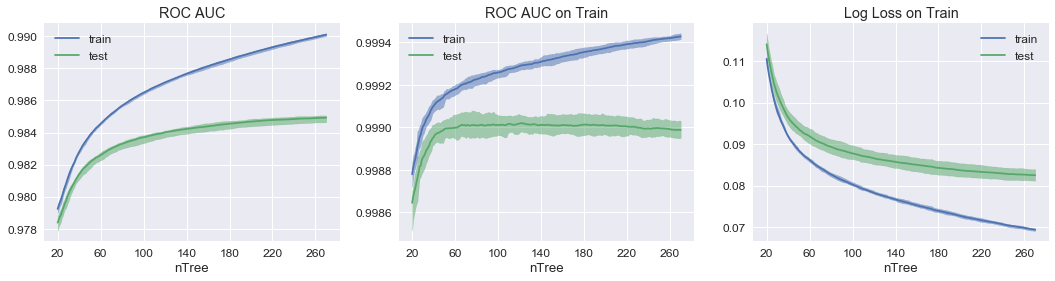

In [292]:
def plot_learning_curves(eval_results, label, metric, i, j, k, title, indexes=np.arange(5)):
    left = 20
    x = np.arange(left, len(eval_results['_0'][0]['tr' + label][metric]))
    
    plt.subplot(i, j, k)
    y_tr_min = np.ones(len(x))
    y_tr_max = np.zeros(len(x))
    y_tr_mean = np.zeros(len(x))

    y_te_min = np.ones(len(x))
    y_te_max = np.zeros(len(x))
    y_te_mean = np.zeros(len(x))
    for suff in suff1:
        y_tr = np.array(eval_results[suff][indexes[0]]['tr' + label][metric][left:])
        y_te = np.array(eval_results[suff][indexes[0]]['te' + label][metric][left:])
        for i in range(1, len(indexes)):
            y_tr += eval_results[suff][indexes[i]]['tr' + label][metric][left:]
            y_te += eval_results[suff][indexes[i]]['te' + label][metric][left:]
        y_tr /= 5
        y_te /= 5
        y_tr_min = np.minimum(y_tr_min, y_tr)
        y_tr_max = np.maximum(y_tr_max, y_tr)
        y_tr_mean += y_tr / len(suff1)
        y_te_min = np.minimum(y_te_min, y_te)
        y_te_max = np.maximum(y_te_max, y_te)
        y_te_mean += y_te / len(suff1)

    plt.plot(x, y_tr_mean, color=sns.color_palette()[0])
    plt.fill_between(x, y_tr_min, y_tr_max, color=list(sns.color_palette()[0]) + [0.5])

    plt.plot(x, y_te_mean, color=sns.color_palette()[1])
    plt.fill_between(x, y_te_min, y_te_max, color=list(sns.color_palette()[1]) + [0.5])
    plt.xticks(np.arange(20, 270, 40))
    plt.xlabel('nTree')
    plt.title(title)
    plt.legend(['train', 'test'])

    
plt.figure(figsize=(18, 4))

plot_learning_curves(eval_results_1, '', 'roc_auc', 1, 3, 1, 'ROC AUC')
plot_learning_curves(eval_results_1, '_tr', 'roc_auc', 1, 3, 2, 'ROC AUC on Train')
plot_learning_curves(eval_results_1, '_tr', 'log_loss', 1, 3, 3, 'Log Loss on Train')

plt.show()

**Важность факторов**

In [239]:
fi1 = dict()
for fi_t in ['weight', 'gain']:
    cm = 0
    fi_w = dict(zip(final_features_model1, [0] * len(final_features_model1)))
    for suff in models_1:
        for i in range(len(models_1[suff])):
            fi_df = common_ml.getFeaturesImportance1(models_1[suff][i].feature_names, models_1[suff][i], importance_type=fi_t)
            for k, v in zip(fi_df.feature, fi_df.importance):
                fi_w[k] += v
        cm += len(models_1[suff])
    
    fi1[fi_t] = pd.DataFrame([(k, v / cm) for k, v in sorted(fi_w.items(), key=lambda x: -x[1])], columns=['feature', 'importance'])
print(cm)

25


In [240]:
display(fi1['weight'].head(10))
display(fi1['gain'].head(10))

,feature,importance
0,qCnt,95.126767
1,upperMaxScore,94.898228
2,max_qsim,74.546718
3,myScore2_q_min,70.221476
4,qrank_for_p,60.409544
5,qp_rank_score_sim,54.176785
6,qWord2_score,51.496585
7,myScore_S_pq_minimax,49.371007
8,sim4_pq_split_w,44.996309
9,myScore_q,40.976956


,feature,importance
0,sim_final,63.780001
1,qp_rank_score,51.499093
2,qrank_for_p,49.260433
3,isBad,35.989956
4,sim4_pq_3chars,31.299633
5,npref_40,28.505901
6,sim4_pq_split_w,25.239297
7,sim4_pq_split,24.362834
8,myScore_S_pq,18.403065
9,npref_30,17.245421


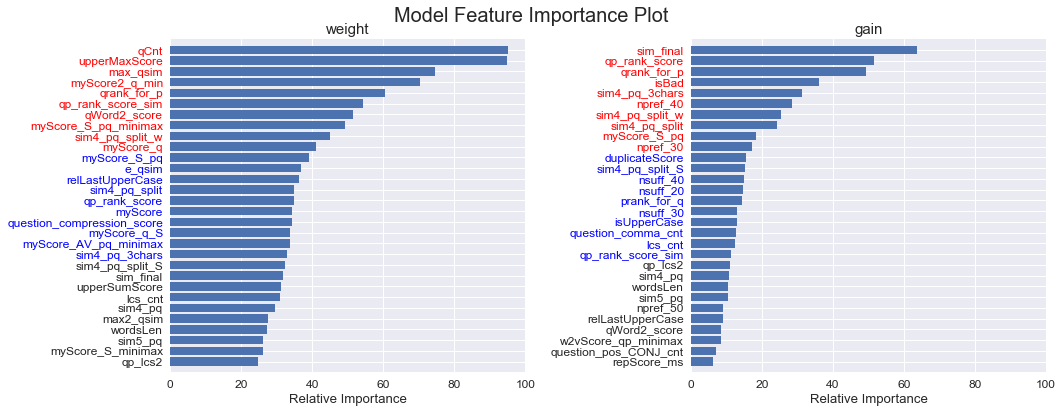

In [241]:
common_ml.drawFeaturesImportancePlot2(fi1['weight'], fi1['gain'], 30, names=['weight', 'gain'])

### Обучение модели 2

Модель обучаем для отделения train выборки от всей test выборки,<br>
**цель - научиться отделять нормальные пары от пар с синтетическими вопросами;**

<center>**Обучение модели 2**<center>
<img src="img/model2.png" width=800px; height=600px>

На картинке:
* зеленым цветом обозначены <font color='green'>**положительные примеры**</font>, красным - <font color='red'>**отрицательные примеры**</font>;
* пунктирным зеленым прямоугольником выделены шумовые примеры, т.е. те для которых при обучении используется НЕправильная разметка;
* заштрихованные области соответствуют частям выборок, которые НЕ используются при обучении модели (используются для оценки качества)

5-fold разбиение обеих выборок используется для двух целей:
* на частях выборок, не участвующих в обучении, можно вычислять метрики качества модели;
* на части тестовой выборки, не участвующей в обучении, можно получать итоговые прогнозы первой модели;

**Метрики, вычисляемые на кросс-валидации:** (вычисляются на частях выборок, участвующих и НЕ участвующих в обучении)
* ROC AUC;
* ROC AUC на "исправленной" выборке;
* log loss на положительных примерах;
* log loss на "исправленных" положительных примерах;

Исправленная разметка формируется после каждого этапа обучения:
* отрицательные примеры из тестовой выборки, предсказание модели для которых велико (>=0.95), преобразуются в положительные примеры (таким образом, устраняется явный шум в разметке);

В итоговом варианте использовалось два этапа обучения (после первого изменялась разметка у ~900 примеров, которая использовалась при обучении на втором этапе).

**Важно**:
Из-за того что в размеченных данных отсутствуют отрицательные примеры(пары параграф-вопрос) с синтетическими вопросами, было проблематично локально оценить ожидаемый результат модели.

Вычисляемые метрики были полезны т.к.:
* коррелировали с получаемыми результатами на открытой части тестовых данных;
* улучшались все вместе при добавлении новых действительно сильных признаков;
* позволяли оценить параметры модели, при которых еще НЕ начинается переобучение;
* позволяли убедиться, что процесс обучения идет в штатном режиме;

**Из-за наличия шума в разметке, оптимизировать отдельно каждую метрику большого смысла не было,** и нужно было соблюдать баланс, чтобы сильно не уйти в различия тренировочных и тестовых человеческих пар, а вытащить отличия именно пар с синтетическими вопросами.

In [220]:
def my_metrics01(pred_probs, dmatrix):
    labels = dmatrix.get_label() # obtain true labels
    try:
        roc_auc =  metrics.roc_auc_score(labels, pred_probs)
    except:
        roc_auc = -1
    try:
        log_loss = -np.mean(np.log(pred_probs))
    except:
        log_loss = -1
    return [('roc_auc', roc_auc), ('log_loss', log_loss)]

In [221]:
num_rounds = 31
watchlist  = [(dtest, 'te'), (dtrain, 'tr'), 
              (dtest0, 'te0'), (dtrain0, 'tr0'), 
              (dtest_positive, 'te_pos'), (dtrain_positive, 'tr_pos'),
              (dtest0_positive, 'te0_pos'), (dtrain0_positive, 'tr0_pos')]

evals_result = {}
xgb_model = xgb.train(xgb_params_0, dtrain, num_rounds, watchlist, feval=my_metrics01, evals_result=evals_result, verbose_eval=10)

[0]	te-roc_auc:0.954453	te-log_loss:0.585196	tr-roc_auc:0.952379	tr-log_loss:0.584988	te0-roc_auc:0.954453	te0-log_loss:0.585196	tr0-roc_auc:0.952379	tr0-log_loss:0.584988	te_pos-roc_auc:-1	te_pos-log_loss:0.530614	tr_pos-roc_auc:-1	tr_pos-log_loss:0.530518	te0_pos-roc_auc:-1	te0_pos-log_loss:0.530614	tr0_pos-roc_auc:-1	tr0_pos-log_loss:0.530518
[10]	te-roc_auc:0.985112	te-log_loss:0.473882	tr-roc_auc:0.983744	tr-log_loss:0.475464	te0-roc_auc:0.985112	te0-log_loss:0.473882	tr0-roc_auc:0.983744	tr0-log_loss:0.475464	te_pos-roc_auc:-1	te_pos-log_loss:0.103555	tr_pos-roc_auc:-1	tr_pos-log_loss:0.103733	te0_pos-roc_auc:-1	te0_pos-log_loss:0.103555	tr0_pos-roc_auc:-1	tr0_pos-log_loss:0.103733
[20]	te-roc_auc:0.986645	te-log_loss:0.607162	tr-roc_auc:0.985265	tr-log_loss:0.607064	te0-roc_auc:0.986645	te0-log_loss:0.607162	tr0-roc_auc:0.985265	tr0-log_loss:0.607064	te_pos-roc_auc:-1	te_pos-log_loss:0.057805	tr_pos-roc_auc:-1	tr_pos-log_loss:0.05782	te0_pos-roc_auc:-1	te0_pos-log_loss:0.057805	

In [229]:
def runModel01(dfp, xgb_params, p_features_final_1, n_iter=1, threshold=0.95, kf_name='p_kf', suff=''):
    print('n_features: {}'.format(len(p_features_final_1)))

    model_list = []
    eval_result_list = []
    dfp['p_target02'] = dfp['p_target01']
    for j in range(n_iter):
        print('Step {}'.format(j))
        print(dfp.p_target02.value_counts(dropna=False))
        dfp['p_isTrPred01'] = -1
        
        te_roc_auc_list = []
        tr_roc_auc_list = []
        te0_roc_auc_list = []
        tr0_roc_auc_list = []
        te_positive_log_loss_list = []
        tr_positive_log_loss_list = []
        te0_positive_log_loss_list = []
        tr0_positive_log_loss_list = []
        
        
        for i in range(nFold):
            print(i, end = ' ')
            ind_tr = dfp[kf_name] != i
            ind_te = dfp[kf_name] == i
            
            ind_tr_positive = ind_tr & (dfp.p_target02 == 1)
            ind_te_positive = ind_te & (dfp.p_target02 == 1)

            ind_tr0_positive = ind_tr & (dfp.p_target01 == 1)
            ind_te0_positive = ind_te & (dfp.p_target01 == 1)
            

            dtrain0 = xgb.DMatrix(dfp.loc[ind_tr, p_features_final], dfp.loc[ind_tr, 'p_target01'])
            dtest0 = xgb.DMatrix(dfp.loc[ind_te, p_features_final], dfp.loc[ind_te, 'p_target01'])
            dtrain = xgb.DMatrix(dfp.loc[ind_tr, p_features_final], dfp.loc[ind_tr, 'p_target02'])
            dtest = xgb.DMatrix(dfp.loc[ind_te, p_features_final], dfp.loc[ind_te, 'p_target02'])

            dtrain0_positive = xgb.DMatrix(dfp.loc[ind_tr0_positive, p_features_final], dfp.loc[ind_tr0_positive, 'p_target01'])
            dtest0_positive = xgb.DMatrix(dfp.loc[ind_te0_positive, p_features_final], dfp.loc[ind_te0_positive, 'p_target01'])            
            dtrain_positive = xgb.DMatrix(dfp.loc[ind_tr_positive, p_features_final], dfp.loc[ind_tr_positive, 'p_target02'])
            dtest_positive = xgb.DMatrix(dfp.loc[ind_te_positive, p_features_final], dfp.loc[ind_te_positive, 'p_target02'])                        
            

            num_rounds = xgb_params['n_estimators']
            watchlist  = [(dtest, 'te'), (dtrain, 'tr'), 
                          (dtest0, 'te0'), (dtrain0, 'tr0'), 
                          (dtest_positive, 'te_pos'), (dtrain_positive, 'tr_pos'),
                          (dtest0_positive, 'te0_pos'), (dtrain0_positive, 'tr0_pos')]
            evals_result = {}
            model = xgb.train(xgb_params, dtrain, num_rounds, watchlist, feval=my_metrics01, evals_result=evals_result, verbose_eval=30)
            

            te_pred = model.predict(dtest)
            tr_pred = model.predict(dtrain)
            te_positive_pred = model.predict(dtest_positive)
            tr_positive_pred = model.predict(dtrain_positive)
            te0_positive_pred = model.predict(dtest0_positive)
            tr0_positive_pred = model.predict(dtrain0_positive)
            
            dfp.loc[ind_te, 'p_isTrPred01'] = te_pred

            te_roc_auc = metrics.roc_auc_score(dfp[ind_te].p_target02, te_pred)
            tr_roc_auc = metrics.roc_auc_score(dfp[ind_tr].p_target02, tr_pred)
            te0_roc_auc = metrics.roc_auc_score(dfp[ind_te].p_target01, te_pred)
            tr0_roc_auc = metrics.roc_auc_score(dfp[ind_tr].p_target01, tr_pred)

            te_positive_log_loss = -np.mean(np.log(te_positive_pred))
            tr_positive_log_loss = -np.mean(np.log(tr_positive_pred))
            te0_positive_log_loss = -np.mean(np.log(te0_positive_pred))
            tr0_positive_log_loss = -np.mean(np.log(tr0_positive_pred))
            

            te_roc_auc_list.append(te_roc_auc)
            tr_roc_auc_list.append(tr_roc_auc)
            te0_roc_auc_list.append(te0_roc_auc)
            tr0_roc_auc_list.append(tr0_roc_auc)

            te_positive_log_loss_list.append(te_positive_log_loss)
            tr_positive_log_loss_list.append(tr_positive_log_loss)
            te0_positive_log_loss_list.append(te0_positive_log_loss)
            tr0_positive_log_loss_list.append(tr0_positive_log_loss)
            
            print()
            print('roc_auc on init sample', te0_roc_auc, tr0_roc_auc)
            print('roc_auc on fixed sample', te_roc_auc, tr_roc_auc)
            print('log_loss on init positive', te0_positive_log_loss, tr0_positive_log_loss)
            print('log_loss on fixed positive', te_positive_log_loss, tr_positive_log_loss)
            print()
            
            model_list.append(model)
            eval_result_list.append(evals_result)
            
        print('mean roc_auc on init sample', np.mean(te0_roc_auc_list), np.mean(tr0_roc_auc_list))
        print('mean roc_auc on fixed sample', np.mean(te_roc_auc_list), np.mean(tr_roc_auc_list))
        print('mean log_loss on init positive', np.mean(te0_positive_log_loss_list), np.mean(tr0_positive_log_loss_list))
        print('mean log_loss on fixed positive', np.mean(te_positive_log_loss_list), np.mean(tr_positive_log_loss_list))
        print()
        
        ind_plus = (dfp.isTr == 0) & (dfp.p_target02 == 0) & (dfp.p_isTrPred01 >=threshold)
        ind_minus = (dfp.isTr == 0) & (dfp.p_target02 == 1) & (dfp.p_target01 == 0) & (dfp.p_isTrPred01 < threshold)
        print(sum(ind_plus), sum(ind_minus))
        print('=======')
        dfp.loc[ind_plus, 'p_target02'] = 1
        dfp.loc[ind_minus, 'p_target02'] = 0
    dfp['p_isTrPred01' + suff] = dfp['p_isTrPred01']
    dfp['p_target02' + suff] = dfp['p_target02']
    return model_list, eval_result_list

Посмотрим на распределение целевой переменной: классы не сбалансированы (~5:1)

In [223]:
display(dfp.p_target01.value_counts(dropna=False).reset_index())

,index,p_target01
0,1,154585
1,0,39099


Обучим модели(и получим предсказания) на пяти разных разбиениях тренировочной и тестовой выборок. В финальном предсказании прогнозы отдельных моделей будут усреднены.

In [290]:
%%time

suff1 = ['_0', '_1', '_2', '_3', '_4']
models_01 = dict()
eval_results_01 = dict()
for i,suff in enumerate(kf_suff):
    xgb_params_i = xgb_params.copy()
    xgb_params_i['seed'] = i + 1
    models_01[suff1[i]], eval_results_01[suff1[i]] = \
        runModel01(dfp, xgb_params_i, final_features_model01, n_iter=2, threshold=0.95, kf_name='p_kf' + suff, suff=suff1[i])
    #break

n_features: 332
Step 0
1    154585
0    39099 
Name: p_target02, dtype: int64
0 [0]	te-roc_auc:0.954453	te-log_loss:0.585196	tr-roc_auc:0.952379	tr-log_loss:0.584988	te0-roc_auc:0.954453	te0-log_loss:0.585196	tr0-roc_auc:0.952379	tr0-log_loss:0.584988	te_pos-roc_auc:-1	te_pos-log_loss:0.530614	tr_pos-roc_auc:-1	tr_pos-log_loss:0.530518	te0_pos-roc_auc:-1	te0_pos-log_loss:0.530614	tr0_pos-roc_auc:-1	tr0_pos-log_loss:0.530518
[30]	te-roc_auc:0.98761	te-log_loss:0.730318	tr-roc_auc:0.98641	tr-log_loss:0.728753	te0-roc_auc:0.98761	te0-log_loss:0.730318	tr0-roc_auc:0.98641	tr0-log_loss:0.728753	te_pos-roc_auc:-1	te_pos-log_loss:0.048235	tr_pos-roc_auc:-1	tr_pos-log_loss:0.048301	te0_pos-roc_auc:-1	te0_pos-log_loss:0.048235	tr0_pos-roc_auc:-1	tr0_pos-log_loss:0.048301
[60]	te-roc_auc:0.988673	te-log_loss:0.918731	tr-roc_auc:0.988038	tr-log_loss:0.913897	te0-roc_auc:0.988673	te0-log_loss:0.918731	tr0-roc_auc:0.988038	tr0-log_loss:0.913897	te_pos-roc_auc:-1	te_pos-log_loss:0.043233	tr_pos-roc_

[90]	te-roc_auc:0.987065	te-log_loss:0.964067	tr-roc_auc:0.989281	tr-log_loss:0.977466	te0-roc_auc:0.987065	te0-log_loss:0.964067	tr0-roc_auc:0.989281	tr0-log_loss:0.977466	te_pos-roc_auc:-1	te_pos-log_loss:0.040934	tr_pos-roc_auc:-1	tr_pos-log_loss:0.039898	te0_pos-roc_auc:-1	te0_pos-log_loss:0.040934	tr0_pos-roc_auc:-1	tr0_pos-log_loss:0.039898
[120]	te-roc_auc:0.987496	te-log_loss:1.01874	tr-roc_auc:0.990087	tr-log_loss:1.0336	te0-roc_auc:0.987496	te0-log_loss:1.01874	tr0-roc_auc:0.990087	tr0-log_loss:1.0336	te_pos-roc_auc:-1	te_pos-log_loss:0.040147	tr_pos-roc_auc:-1	tr_pos-log_loss:0.038326	te0_pos-roc_auc:-1	te0_pos-log_loss:0.040147	tr0_pos-roc_auc:-1	tr0_pos-log_loss:0.038326
[150]	te-roc_auc:0.987767	te-log_loss:1.07137	tr-roc_auc:0.990655	tr-log_loss:1.08732	te0-roc_auc:0.987767	te0-log_loss:1.07137	tr0-roc_auc:0.990655	tr0-log_loss:1.08732	te_pos-roc_auc:-1	te_pos-log_loss:0.039239	tr_pos-roc_auc:-1	tr_pos-log_loss:0.037184	te0_pos-roc_auc:-1	te0_pos-log_loss:0.039239	tr0_po

[180]	te-roc_auc:0.988625	te-log_loss:1.10871	tr-roc_auc:0.991005	tr-log_loss:1.12494	te0-roc_auc:0.988625	te0-log_loss:1.10871	tr0-roc_auc:0.991005	tr0-log_loss:1.12494	te_pos-roc_auc:-1	te_pos-log_loss:0.040227	tr_pos-roc_auc:-1	tr_pos-log_loss:0.03662	te0_pos-roc_auc:-1	te0_pos-log_loss:0.040227	tr0_pos-roc_auc:-1	tr0_pos-log_loss:0.03662
[210]	te-roc_auc:0.988693	te-log_loss:1.13496	tr-roc_auc:0.991516	tr-log_loss:1.15195	te0-roc_auc:0.988693	te0-log_loss:1.13496	tr0-roc_auc:0.991516	tr0-log_loss:1.15195	te_pos-roc_auc:-1	te_pos-log_loss:0.039947	tr_pos-roc_auc:-1	tr_pos-log_loss:0.035723	te0_pos-roc_auc:-1	te0_pos-log_loss:0.039947	tr0_pos-roc_auc:-1	tr0_pos-log_loss:0.035723
[240]	te-roc_auc:0.988721	te-log_loss:1.15853	tr-roc_auc:0.991928	tr-log_loss:1.17609	te0-roc_auc:0.988721	te0-log_loss:1.15853	tr0-roc_auc:0.991928	tr0-log_loss:1.17609	te_pos-roc_auc:-1	te_pos-log_loss:0.039885	tr_pos-roc_auc:-1	tr_pos-log_loss:0.03512	te0_pos-roc_auc:-1	te0_pos-log_loss:0.039885	tr0_pos-ro

[240]	te-roc_auc:0.993168	te-log_loss:1.37793	tr-roc_auc:0.996425	tr-log_loss:1.2304	te0-roc_auc:0.985613	te0-log_loss:1.37793	tr0-roc_auc:0.990992	tr0-log_loss:1.2304	te_pos-roc_auc:-1	te_pos-log_loss:0.037161	tr_pos-roc_auc:-1	tr_pos-log_loss:0.026647	te0_pos-roc_auc:-1	te0_pos-log_loss:0.037338	tr0_pos-roc_auc:-1	tr0_pos-log_loss:0.026697
[270]	te-roc_auc:0.993227	te-log_loss:1.40542	tr-roc_auc:0.996692	tr-log_loss:1.25509	te0-roc_auc:0.985687	te0-log_loss:1.40542	tr0-roc_auc:0.991251	tr0-log_loss:1.25509	te_pos-roc_auc:-1	te_pos-log_loss:0.037098	tr_pos-roc_auc:-1	tr_pos-log_loss:0.026043	te0_pos-roc_auc:-1	te0_pos-log_loss:0.037276	tr0_pos-roc_auc:-1	tr0_pos-log_loss:0.026091

roc_auc on init sample 0.985687419889 0.991251455856
roc_auc on fixed sample 0.993227025084 0.996692158677
log_loss on init positive 0.0372763 0.0260914
log_loss on fixed positive 0.0370983 0.0260427

2 [0]	te-roc_auc:0.958634	te-log_loss:0.582885	tr-roc_auc:0.960407	tr-log_loss:0.583099	te0-roc_auc:0.953247

log_loss on fixed positive 0.0289787 0.0277853

4 [0]	te-roc_auc:0.96924	te-log_loss:0.583405	tr-roc_auc:0.96859	tr-log_loss:0.584329	te0-roc_auc:0.964212	te0-log_loss:0.583405	tr0-roc_auc:0.962308	tr0-log_loss:0.584329	te_pos-roc_auc:-1	te_pos-log_loss:0.526134	tr_pos-roc_auc:-1	tr_pos-log_loss:0.526104	te0_pos-roc_auc:-1	te0_pos-log_loss:0.525981	tr0_pos-roc_auc:-1	tr0_pos-log_loss:0.525998
[30]	te-roc_auc:0.991554	te-log_loss:0.727987	tr-roc_auc:0.991798	tr-log_loss:0.73613	te0-roc_auc:0.986656	te0-log_loss:0.727987	tr0-roc_auc:0.986091	tr0-log_loss:0.73613	te_pos-roc_auc:-1	te_pos-log_loss:0.042897	tr_pos-roc_auc:-1	tr_pos-log_loss:0.042229	te0_pos-roc_auc:-1	te0_pos-log_loss:0.042857	tr0_pos-roc_auc:-1	tr0_pos-log_loss:0.042207
[60]	te-roc_auc:0.992862	te-log_loss:0.935376	tr-roc_auc:0.993374	tr-log_loss:0.947633	te0-roc_auc:0.987759	te0-log_loss:0.935376	tr0-roc_auc:0.987593	tr0-log_loss:0.947633	te_pos-roc_auc:-1	te_pos-log_loss:0.037169	tr_pos-roc_auc:-1	tr_pos-log_loss:0.03562

[60]	te-roc_auc:0.988716	te-log_loss:0.854601	tr-roc_auc:0.987818	tr-log_loss:0.93549	te0-roc_auc:0.988716	te0-log_loss:0.854601	tr0-roc_auc:0.987818	tr0-log_loss:0.93549	te_pos-roc_auc:-1	te_pos-log_loss:0.037761	tr_pos-roc_auc:-1	tr_pos-log_loss:0.043458	te0_pos-roc_auc:-1	te0_pos-log_loss:0.037761	tr0_pos-roc_auc:-1	tr0_pos-log_loss:0.043458
[90]	te-roc_auc:0.989198	te-log_loss:0.925644	tr-roc_auc:0.98891	tr-log_loss:1.0125	te0-roc_auc:0.989198	te0-log_loss:0.925644	tr0-roc_auc:0.98891	tr0-log_loss:1.0125	te_pos-roc_auc:-1	te_pos-log_loss:0.036292	tr_pos-roc_auc:-1	tr_pos-log_loss:0.04133	te0_pos-roc_auc:-1	te0_pos-log_loss:0.036292	tr0_pos-roc_auc:-1	tr0_pos-log_loss:0.04133
[120]	te-roc_auc:0.989403	te-log_loss:0.970012	tr-roc_auc:0.98957	tr-log_loss:1.06139	te0-roc_auc:0.989403	te0-log_loss:0.970012	tr0-roc_auc:0.98957	tr0-log_loss:1.06139	te_pos-roc_auc:-1	te_pos-log_loss:0.03547	tr_pos-roc_auc:-1	tr_pos-log_loss:0.039984	te0_pos-roc_auc:-1	te0_pos-log_loss:0.03547	tr0_pos-roc_a

[150]	te-roc_auc:0.9885	te-log_loss:0.921882	tr-roc_auc:0.990364	tr-log_loss:1.13075	te0-roc_auc:0.9885	te0-log_loss:0.921882	tr0-roc_auc:0.990364	tr0-log_loss:1.13075	te_pos-roc_auc:-1	te_pos-log_loss:0.033192	tr_pos-roc_auc:-1	tr_pos-log_loss:0.038858	te0_pos-roc_auc:-1	te0_pos-log_loss:0.033192	tr0_pos-roc_auc:-1	tr0_pos-log_loss:0.038858
[180]	te-roc_auc:0.988638	te-log_loss:0.953425	tr-roc_auc:0.990875	tr-log_loss:1.17028	te0-roc_auc:0.988638	te0-log_loss:0.953425	tr0-roc_auc:0.990875	tr0-log_loss:1.17028	te_pos-roc_auc:-1	te_pos-log_loss:0.032746	tr_pos-roc_auc:-1	tr_pos-log_loss:0.037911	te0_pos-roc_auc:-1	te0_pos-log_loss:0.032746	tr0_pos-roc_auc:-1	tr0_pos-log_loss:0.037911
[210]	te-roc_auc:0.988592	te-log_loss:0.974472	tr-roc_auc:0.991373	tr-log_loss:1.19715	te0-roc_auc:0.988592	te0-log_loss:0.974472	tr0-roc_auc:0.991373	tr0-log_loss:1.19715	te_pos-roc_auc:-1	te_pos-log_loss:0.032533	tr_pos-roc_auc:-1	tr_pos-log_loss:0.037072	te0_pos-roc_auc:-1	te0_pos-log_loss:0.032533	tr0_p

[210]	te-roc_auc:0.993391	te-log_loss:1.34323	tr-roc_auc:0.995917	tr-log_loss:1.19759	te0-roc_auc:0.988298	te0-log_loss:1.34323	tr0-roc_auc:0.990208	tr0-log_loss:1.19759	te_pos-roc_auc:-1	te_pos-log_loss:0.038217	tr_pos-roc_auc:-1	tr_pos-log_loss:0.028205	te0_pos-roc_auc:-1	te0_pos-log_loss:0.038331	tr0_pos-roc_auc:-1	tr0_pos-log_loss:0.028262
[240]	te-roc_auc:0.993438	te-log_loss:1.38126	tr-roc_auc:0.996162	tr-log_loss:1.23188	te0-roc_auc:0.988349	te0-log_loss:1.38126	tr0-roc_auc:0.99045	tr0-log_loss:1.23188	te_pos-roc_auc:-1	te_pos-log_loss:0.037934	tr_pos-roc_auc:-1	tr_pos-log_loss:0.027417	te0_pos-roc_auc:-1	te0_pos-log_loss:0.038048	tr0_pos-roc_auc:-1	tr0_pos-log_loss:0.027473
[270]	te-roc_auc:0.993517	te-log_loss:1.41185	tr-roc_auc:0.996445	tr-log_loss:1.25957	te0-roc_auc:0.988418	te0-log_loss:1.41185	tr0-roc_auc:0.990735	tr0-log_loss:1.25957	te_pos-roc_auc:-1	te_pos-log_loss:0.037747	tr_pos-roc_auc:-1	tr_pos-log_loss:0.026753	te0_pos-roc_auc:-1	te0_pos-log_loss:0.037862	tr0_pos-


roc_auc on init sample 0.987256945339 0.99100351351
roc_auc on fixed sample 0.993451215163 0.996444345129
log_loss on init positive 0.0371374 0.0266584
log_loss on fixed positive 0.0369855 0.0266139

3 [0]	te-roc_auc:0.97259	te-log_loss:0.572677	tr-roc_auc:0.967012	tr-log_loss:0.587077	te0-roc_auc:0.965863	te0-log_loss:0.572677	tr0-roc_auc:0.961675	tr0-log_loss:0.587077	te_pos-roc_auc:-1	te_pos-log_loss:0.523619	tr_pos-roc_auc:-1	tr_pos-log_loss:0.527819	te0_pos-roc_auc:-1	te0_pos-log_loss:0.523516	tr0_pos-roc_auc:-1	tr0_pos-log_loss:0.527694
[30]	te-roc_auc:0.992391	te-log_loss:0.615631	tr-roc_auc:0.991334	tr-log_loss:0.755331	te0-roc_auc:0.986964	te0-log_loss:0.615631	tr0-roc_auc:0.985941	tr0-log_loss:0.755331	te_pos-roc_auc:-1	te_pos-log_loss:0.035242	tr_pos-roc_auc:-1	tr_pos-log_loss:0.043847	te0_pos-roc_auc:-1	te0_pos-log_loss:0.035185	tr0_pos-roc_auc:-1	tr0_pos-log_loss:0.04381
[60]	te-roc_auc:0.993459	te-log_loss:0.789598	tr-roc_auc:0.993019	tr-log_loss:0.968149	te0-roc_auc:0.9

[60]	te-roc_auc:0.987748	te-log_loss:0.885501	tr-roc_auc:0.988066	tr-log_loss:0.936755	te0-roc_auc:0.987748	te0-log_loss:0.885501	tr0-roc_auc:0.988066	tr0-log_loss:0.936755	te_pos-roc_auc:-1	te_pos-log_loss:0.041942	tr_pos-roc_auc:-1	tr_pos-log_loss:0.042525	te0_pos-roc_auc:-1	te0_pos-log_loss:0.041942	tr0_pos-roc_auc:-1	tr0_pos-log_loss:0.042525
[90]	te-roc_auc:0.988069	te-log_loss:0.949044	tr-roc_auc:0.989134	tr-log_loss:1.00467	te0-roc_auc:0.988069	te0-log_loss:0.949044	tr0-roc_auc:0.989134	tr0-log_loss:1.00467	te_pos-roc_auc:-1	te_pos-log_loss:0.040603	tr_pos-roc_auc:-1	tr_pos-log_loss:0.0404	te0_pos-roc_auc:-1	te0_pos-log_loss:0.040603	tr0_pos-roc_auc:-1	tr0_pos-log_loss:0.0404
[120]	te-roc_auc:0.988269	te-log_loss:1.01072	tr-roc_auc:0.989864	tr-log_loss:1.06939	te0-roc_auc:0.988269	te0-log_loss:1.01072	tr0-roc_auc:0.989864	tr0-log_loss:1.06939	te_pos-roc_auc:-1	te_pos-log_loss:0.039657	tr_pos-roc_auc:-1	tr_pos-log_loss:0.038844	te0_pos-roc_auc:-1	te0_pos-log_loss:0.039657	tr0_pos

[150]	te-roc_auc:0.987676	te-log_loss:1.19599	tr-roc_auc:0.990722	tr-log_loss:1.11048	te0-roc_auc:0.987676	te0-log_loss:1.19599	tr0-roc_auc:0.990722	tr0-log_loss:1.11048	te_pos-roc_auc:-1	te_pos-log_loss:0.045032	tr_pos-roc_auc:-1	tr_pos-log_loss:0.037059	te0_pos-roc_auc:-1	te0_pos-log_loss:0.045032	tr0_pos-roc_auc:-1	tr0_pos-log_loss:0.037059
[180]	te-roc_auc:0.987799	te-log_loss:1.23851	tr-roc_auc:0.991207	tr-log_loss:1.14981	te0-roc_auc:0.987799	te0-log_loss:1.23851	tr0-roc_auc:0.991207	tr0-log_loss:1.14981	te_pos-roc_auc:-1	te_pos-log_loss:0.044585	tr_pos-roc_auc:-1	tr_pos-log_loss:0.036033	te0_pos-roc_auc:-1	te0_pos-log_loss:0.044585	tr0_pos-roc_auc:-1	tr0_pos-log_loss:0.036033
[210]	te-roc_auc:0.987871	te-log_loss:1.26709	tr-roc_auc:0.991697	tr-log_loss:1.17814	te0-roc_auc:0.987871	te0-log_loss:1.26709	tr0-roc_auc:0.991697	tr0-log_loss:1.17814	te_pos-roc_auc:-1	te_pos-log_loss:0.044075	tr_pos-roc_auc:-1	tr_pos-log_loss:0.03511	te0_pos-roc_auc:-1	te0_pos-log_loss:0.044075	tr0_pos-

[240]	te-roc_auc:0.986128	te-log_loss:1.26729	tr-roc_auc:0.992332	tr-log_loss:1.17048	te0-roc_auc:0.986128	te0-log_loss:1.26729	tr0-roc_auc:0.992332	tr0-log_loss:1.17048	te_pos-roc_auc:-1	te_pos-log_loss:0.043279	tr_pos-roc_auc:-1	tr_pos-log_loss:0.033539	te0_pos-roc_auc:-1	te0_pos-log_loss:0.043279	tr0_pos-roc_auc:-1	tr0_pos-log_loss:0.033539
[270]	te-roc_auc:0.986291	te-log_loss:1.29181	tr-roc_auc:0.99271	tr-log_loss:1.19234	te0-roc_auc:0.986291	te0-log_loss:1.29181	tr0-roc_auc:0.99271	tr0-log_loss:1.19234	te_pos-roc_auc:-1	te_pos-log_loss:0.042889	tr_pos-roc_auc:-1	tr_pos-log_loss:0.032828	te0_pos-roc_auc:-1	te0_pos-log_loss:0.042889	tr0_pos-roc_auc:-1	tr0_pos-log_loss:0.032828

roc_auc on init sample 0.986290946597 0.992709901592
roc_auc on fixed sample 0.986290946597 0.992709901592
log_loss on init positive 0.042889 0.0328282
log_loss on fixed positive 0.042889 0.0328282

mean roc_auc on init sample 0.98828010903 0.992433681094
mean roc_auc on fixed sample 0.98828010903 0.99243368


roc_auc on init sample 0.988882457139 0.990632833832
roc_auc on fixed sample 0.993624947599 0.996465819343
log_loss on init positive 0.0319116 0.0272863
log_loss on fixed positive 0.0318232 0.0272349

2 [0]	te-roc_auc:0.967123	te-log_loss:0.588137	tr-roc_auc:0.969787	tr-log_loss:0.582637	te0-roc_auc:0.961643	te0-log_loss:0.588137	tr0-roc_auc:0.964261	tr0-log_loss:0.582637	te_pos-roc_auc:-1	te_pos-log_loss:0.529113	tr_pos-roc_auc:-1	tr_pos-log_loss:0.527108	te0_pos-roc_auc:-1	te0_pos-log_loss:0.528999	tr0_pos-roc_auc:-1	tr0_pos-log_loss:0.526958
[30]	te-roc_auc:0.990866	te-log_loss:0.768526	tr-roc_auc:0.991724	tr-log_loss:0.711703	te0-roc_auc:0.985424	te0-log_loss:0.768526	tr0-roc_auc:0.986452	tr0-log_loss:0.711703	te_pos-roc_auc:-1	te_pos-log_loss:0.047367	tr_pos-roc_auc:-1	tr_pos-log_loss:0.041876	te0_pos-roc_auc:-1	te0_pos-log_loss:0.047372	tr0_pos-roc_auc:-1	tr0_pos-log_loss:0.041823
[60]	te-roc_auc:0.992091	te-log_loss:1.01179	tr-roc_auc:0.993325	tr-log_loss:0.935469	te0-roc_auc:0

[60]	te-roc_auc:0.991396	te-log_loss:0.999105	tr-roc_auc:0.993442	tr-log_loss:0.920117	te0-roc_auc:0.984397	te0-log_loss:0.999105	tr0-roc_auc:0.988321	tr0-log_loss:0.920117	te_pos-roc_auc:-1	te_pos-log_loss:0.041087	tr_pos-roc_auc:-1	tr_pos-log_loss:0.034402	te0_pos-roc_auc:-1	te0_pos-log_loss:0.041215	tr0_pos-roc_auc:-1	tr0_pos-log_loss:0.03442
[90]	te-roc_auc:0.992029	te-log_loss:1.09243	tr-roc_auc:0.994284	tr-log_loss:1.0081	te0-roc_auc:0.984985	te0-log_loss:1.09243	tr0-roc_auc:0.989105	tr0-log_loss:1.0081	te_pos-roc_auc:-1	te_pos-log_loss:0.039243	tr_pos-roc_auc:-1	tr_pos-log_loss:0.032183	te0_pos-roc_auc:-1	te0_pos-log_loss:0.039387	tr0_pos-roc_auc:-1	tr0_pos-log_loss:0.032219
[120]	te-roc_auc:0.992393	te-log_loss:1.17761	tr-roc_auc:0.994892	tr-log_loss:1.08696	te0-roc_auc:0.985296	te0-log_loss:1.17761	tr0-roc_auc:0.989682	tr0-log_loss:1.08696	te_pos-roc_auc:-1	te_pos-log_loss:0.038327	tr_pos-roc_auc:-1	tr_pos-log_loss:0.030781	te0_pos-roc_auc:-1	te0_pos-log_loss:0.038475	tr0_pos-

[120]	te-roc_auc:0.984936	te-log_loss:1.22974	tr-roc_auc:0.990466	tr-log_loss:1.03057	te0-roc_auc:0.984936	te0-log_loss:1.22974	tr0-roc_auc:0.990466	tr0-log_loss:1.03057	te_pos-roc_auc:-1	te_pos-log_loss:0.047908	tr_pos-roc_auc:-1	tr_pos-log_loss:0.036627	te0_pos-roc_auc:-1	te0_pos-log_loss:0.047908	tr0_pos-roc_auc:-1	tr0_pos-log_loss:0.036627
[150]	te-roc_auc:0.985164	te-log_loss:1.28065	tr-roc_auc:0.991015	tr-log_loss:1.07418	te0-roc_auc:0.985164	te0-log_loss:1.28065	tr0-roc_auc:0.991015	tr0-log_loss:1.07418	te_pos-roc_auc:-1	te_pos-log_loss:0.046813	tr_pos-roc_auc:-1	tr_pos-log_loss:0.035572	te0_pos-roc_auc:-1	te0_pos-log_loss:0.046813	tr0_pos-roc_auc:-1	tr0_pos-log_loss:0.035572
[180]	te-roc_auc:0.985356	te-log_loss:1.31139	tr-roc_auc:0.991488	tr-log_loss:1.1011	te0-roc_auc:0.985356	te0-log_loss:1.31139	tr0-roc_auc:0.991488	tr0-log_loss:1.1011	te_pos-roc_auc:-1	te_pos-log_loss:0.046042	tr_pos-roc_auc:-1	tr_pos-log_loss:0.034664	te0_pos-roc_auc:-1	te0_pos-log_loss:0.046042	tr0_pos-r

[210]	te-roc_auc:0.990663	te-log_loss:0.985236	tr-roc_auc:0.991102	tr-log_loss:1.22375	te0-roc_auc:0.990663	te0-log_loss:0.985236	tr0-roc_auc:0.991102	tr0-log_loss:1.22375	te_pos-roc_auc:-1	te_pos-log_loss:0.033625	tr_pos-roc_auc:-1	tr_pos-log_loss:0.038222	te0_pos-roc_auc:-1	te0_pos-log_loss:0.033625	tr0_pos-roc_auc:-1	tr0_pos-log_loss:0.038222
[240]	te-roc_auc:0.990705	te-log_loss:1.00153	tr-roc_auc:0.99153	tr-log_loss:1.24382	te0-roc_auc:0.990705	te0-log_loss:1.00153	tr0-roc_auc:0.99153	tr0-log_loss:1.24382	te_pos-roc_auc:-1	te_pos-log_loss:0.033445	tr_pos-roc_auc:-1	tr_pos-log_loss:0.037345	te0_pos-roc_auc:-1	te0_pos-log_loss:0.033445	tr0_pos-roc_auc:-1	tr0_pos-log_loss:0.037345
[270]	te-roc_auc:0.990754	te-log_loss:1.015	tr-roc_auc:0.991974	tr-log_loss:1.26149	te0-roc_auc:0.990754	te0-log_loss:1.015	tr0-roc_auc:0.991974	tr0-log_loss:1.26149	te_pos-roc_auc:-1	te_pos-log_loss:0.033483	tr_pos-roc_auc:-1	tr_pos-log_loss:0.036826	te0_pos-roc_auc:-1	te0_pos-log_loss:0.033483	tr0_pos-roc

[270]	te-roc_auc:0.9936	te-log_loss:1.34943	tr-roc_auc:0.996433	tr-log_loss:1.30999	te0-roc_auc:0.988266	te0-log_loss:1.34943	tr0-roc_auc:0.990678	tr0-log_loss:1.30999	te_pos-roc_auc:-1	te_pos-log_loss:0.032987	tr_pos-roc_auc:-1	tr_pos-log_loss:0.027058	te0_pos-roc_auc:-1	te0_pos-log_loss:0.033071	tr0_pos-roc_auc:-1	tr0_pos-log_loss:0.027121

roc_auc on init sample 0.988266193747 0.990677744981
roc_auc on fixed sample 0.993599922565 0.996433485113
log_loss on init positive 0.0330706 0.0271208
log_loss on fixed positive 0.0329866 0.0270584

1 [0]	te-roc_auc:0.960526	te-log_loss:0.595509	tr-roc_auc:0.968007	tr-log_loss:0.580971	te0-roc_auc:0.954353	te0-log_loss:0.595509	tr0-roc_auc:0.962881	tr0-log_loss:0.580971	te_pos-roc_auc:-1	te_pos-log_loss:0.532086	tr_pos-roc_auc:-1	tr_pos-log_loss:0.526891	te0_pos-roc_auc:-1	te0_pos-log_loss:0.531911	tr0_pos-roc_auc:-1	tr0_pos-log_loss:0.526769
[30]	te-roc_auc:0.989327	te-log_loss:0.835641	tr-roc_auc:0.991736	tr-log_loss:0.700433	te0-roc_auc:0.982

[30]	te-roc_auc:0.993004	te-log_loss:0.615807	tr-roc_auc:0.991174	tr-log_loss:0.765736	te0-roc_auc:0.988809	te0-log_loss:0.615807	tr0-roc_auc:0.985428	tr0-log_loss:0.765736	te_pos-roc_auc:-1	te_pos-log_loss:0.035982	tr_pos-roc_auc:-1	tr_pos-log_loss:0.045287	te0_pos-roc_auc:-1	te0_pos-log_loss:0.035932	tr0_pos-roc_auc:-1	tr0_pos-log_loss:0.045257
[60]	te-roc_auc:0.994098	te-log_loss:0.804168	tr-roc_auc:0.992897	tr-log_loss:0.999071	te0-roc_auc:0.989785	te0-log_loss:0.804168	tr0-roc_auc:0.987089	tr0-log_loss:0.999071	te_pos-roc_auc:-1	te_pos-log_loss:0.030655	tr_pos-roc_auc:-1	tr_pos-log_loss:0.038103	te0_pos-roc_auc:-1	te0_pos-log_loss:0.030661	tr0_pos-roc_auc:-1	tr0_pos-log_loss:0.03814
[90]	te-roc_auc:0.99451	te-log_loss:0.906565	tr-roc_auc:0.993884	tr-log_loss:1.12639	te0-roc_auc:0.990098	te0-log_loss:0.906565	tr0-roc_auc:0.987991	tr0-log_loss:1.12639	te_pos-roc_auc:-1	te_pos-log_loss:0.029117	tr_pos-roc_auc:-1	tr_pos-log_loss:0.035293	te0_pos-roc_auc:-1	te0_pos-log_loss:0.029142	tr

[90]	te-roc_auc:0.98847	te-log_loss:0.955227	tr-roc_auc:0.988971	tr-log_loss:1.00423	te0-roc_auc:0.98847	te0-log_loss:0.955227	tr0-roc_auc:0.988971	tr0-log_loss:1.00423	te_pos-roc_auc:-1	te_pos-log_loss:0.041521	tr_pos-roc_auc:-1	tr_pos-log_loss:0.040605	te0_pos-roc_auc:-1	te0_pos-log_loss:0.041521	tr0_pos-roc_auc:-1	tr0_pos-log_loss:0.040605
[120]	te-roc_auc:0.988747	te-log_loss:1.01962	tr-roc_auc:0.989938	tr-log_loss:1.0731	te0-roc_auc:0.988747	te0-log_loss:1.01962	tr0-roc_auc:0.989938	tr0-log_loss:1.0731	te_pos-roc_auc:-1	te_pos-log_loss:0.040309	tr_pos-roc_auc:-1	tr_pos-log_loss:0.038758	te0_pos-roc_auc:-1	te0_pos-log_loss:0.040309	tr0_pos-roc_auc:-1	tr0_pos-log_loss:0.038758
[150]	te-roc_auc:0.988925	te-log_loss:1.05807	tr-roc_auc:0.990585	tr-log_loss:1.11327	te0-roc_auc:0.988925	te0-log_loss:1.05807	tr0-roc_auc:0.990585	tr0-log_loss:1.11327	te_pos-roc_auc:-1	te_pos-log_loss:0.039859	tr_pos-roc_auc:-1	tr_pos-log_loss:0.037715	te0_pos-roc_auc:-1	te0_pos-log_loss:0.039859	tr0_pos-ro

[180]	te-roc_auc:0.988511	te-log_loss:1.03704	tr-roc_auc:0.991	tr-log_loss:1.16076	te0-roc_auc:0.988511	te0-log_loss:1.03704	tr0-roc_auc:0.991	tr0-log_loss:1.16076	te_pos-roc_auc:-1	te_pos-log_loss:0.034896	tr_pos-roc_auc:-1	tr_pos-log_loss:0.037366	te0_pos-roc_auc:-1	te0_pos-log_loss:0.034896	tr0_pos-roc_auc:-1	tr0_pos-log_loss:0.037366
[210]	te-roc_auc:0.988584	te-log_loss:1.05416	tr-roc_auc:0.991478	tr-log_loss:1.1803	te0-roc_auc:0.988584	te0-log_loss:1.05416	tr0-roc_auc:0.991478	tr0-log_loss:1.1803	te_pos-roc_auc:-1	te_pos-log_loss:0.034359	tr_pos-roc_auc:-1	tr_pos-log_loss:0.036425	te0_pos-roc_auc:-1	te0_pos-log_loss:0.034359	tr0_pos-roc_auc:-1	tr0_pos-log_loss:0.036425
[240]	te-roc_auc:0.988689	te-log_loss:1.0786	tr-roc_auc:0.991913	tr-log_loss:1.20831	te0-roc_auc:0.988689	te0-log_loss:1.0786	tr0-roc_auc:0.991913	tr0-log_loss:1.20831	te_pos-roc_auc:-1	te_pos-log_loss:0.034158	tr_pos-roc_auc:-1	tr_pos-log_loss:0.03577	te0_pos-roc_auc:-1	te0_pos-log_loss:0.034158	tr0_pos-roc_auc:-1

[270]	te-roc_auc:0.987069	te-log_loss:1.37865	tr-roc_auc:0.992699	tr-log_loss:1.16506	te0-roc_auc:0.987069	te0-log_loss:1.37865	tr0-roc_auc:0.992699	tr0-log_loss:1.16506	te_pos-roc_auc:-1	te_pos-log_loss:0.047478	tr_pos-roc_auc:-1	tr_pos-log_loss:0.032823	te0_pos-roc_auc:-1	te0_pos-log_loss:0.047478	tr0_pos-roc_auc:-1	tr0_pos-log_loss:0.032823

roc_auc on init sample 0.987069091914 0.992698685964
roc_auc on fixed sample 0.987069091914 0.992698685964
log_loss on init positive 0.0474776 0.0328234
log_loss on fixed positive 0.0474776 0.0328234

mean roc_auc on init sample 0.988408222154 0.992396440168
mean roc_auc on fixed sample 0.988408222154 0.992396440168
mean log_loss on init positive 0.0392938 0.0342555
mean log_loss on fixed positive 0.0392938 0.0342555

888 0
Step 1
1    155473
0    38211 
Name: p_target02, dtype: int64
0 [0]	te-roc_auc:0.963521	te-log_loss:0.580358	tr-roc_auc:0.961799	tr-log_loss:0.584435	te0-roc_auc:0.958652	te0-log_loss:0.580358	tr0-roc_auc:0.956286	tr0-log_los

[30]	te-roc_auc:0.991605	te-log_loss:0.663299	tr-roc_auc:0.991507	tr-log_loss:0.74134	te0-roc_auc:0.986178	te0-log_loss:0.663299	tr0-roc_auc:0.986133	tr0-log_loss:0.74134	te_pos-roc_auc:-1	te_pos-log_loss:0.038549	tr_pos-roc_auc:-1	tr_pos-log_loss:0.043711	te0_pos-roc_auc:-1	te0_pos-log_loss:0.03849	tr0_pos-roc_auc:-1	tr0_pos-log_loss:0.043686
[60]	te-roc_auc:0.992709	te-log_loss:0.867064	tr-roc_auc:0.993192	tr-log_loss:0.969286	te0-roc_auc:0.987151	te0-log_loss:0.867064	tr0-roc_auc:0.987738	tr0-log_loss:0.969286	te_pos-roc_auc:-1	te_pos-log_loss:0.032952	tr_pos-roc_auc:-1	tr_pos-log_loss:0.036823	te0_pos-roc_auc:-1	te0_pos-log_loss:0.032973	tr0_pos-roc_auc:-1	tr0_pos-log_loss:0.036861
[90]	te-roc_auc:0.99336	te-log_loss:0.968317	tr-roc_auc:0.994107	tr-log_loss:1.08201	te0-roc_auc:0.987747	te0-log_loss:0.968317	tr0-roc_auc:0.988587	tr0-log_loss:1.08201	te_pos-roc_auc:-1	te_pos-log_loss:0.031136	tr_pos-roc_auc:-1	tr_pos-log_loss:0.034227	te0_pos-roc_auc:-1	te0_pos-log_loss:0.031178	tr0_

[120]	te-roc_auc:0.992555	te-log_loss:1.27277	tr-roc_auc:0.994867	tr-log_loss:1.0733	te0-roc_auc:0.986336	te0-log_loss:1.27277	tr0-roc_auc:0.989538	tr0-log_loss:1.0733	te_pos-roc_auc:-1	te_pos-log_loss:0.04112	tr_pos-roc_auc:-1	tr_pos-log_loss:0.030381	te0_pos-roc_auc:-1	te0_pos-log_loss:0.041273	tr0_pos-roc_auc:-1	tr0_pos-log_loss:0.030415
[150]	te-roc_auc:0.992823	te-log_loss:1.32917	tr-roc_auc:0.995346	tr-log_loss:1.12322	te0-roc_auc:0.986583	te0-log_loss:1.32917	tr0-roc_auc:0.989959	tr0-log_loss:1.12322	te_pos-roc_auc:-1	te_pos-log_loss:0.04005	tr_pos-roc_auc:-1	tr_pos-log_loss:0.029127	te0_pos-roc_auc:-1	te0_pos-log_loss:0.040209	tr0_pos-roc_auc:-1	tr0_pos-log_loss:0.029168
[180]	te-roc_auc:0.993036	te-log_loss:1.36988	tr-roc_auc:0.995773	tr-log_loss:1.1581	te0-roc_auc:0.986761	te0-log_loss:1.36988	tr0-roc_auc:0.990362	tr0-log_loss:1.1581	te_pos-roc_auc:-1	te_pos-log_loss:0.039449	tr_pos-roc_auc:-1	tr_pos-log_loss:0.028147	te0_pos-roc_auc:-1	te0_pos-log_loss:0.039612	tr0_pos-roc_a

**Кривые обучения**

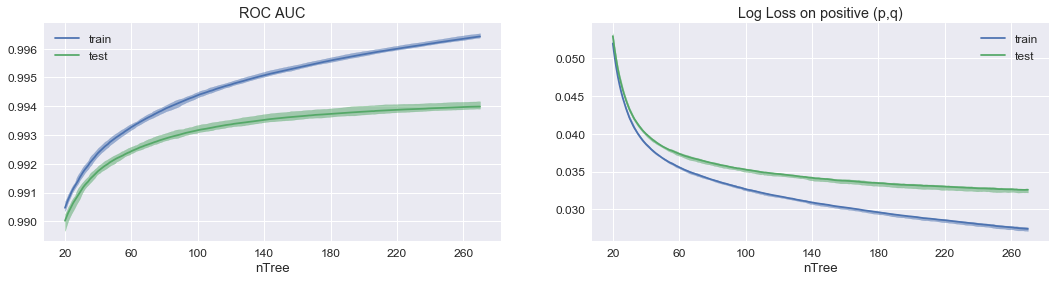

In [372]:
plt.figure(figsize=(18, 4))

plot_learning_curves(eval_results_01, '', 'roc_auc', 1, 2, 1, 'ROC AUC', indexes=np.arange(5, 10))
plot_learning_curves(eval_results_01, '_pos', 'log_loss', 1, 2, 2, 'Log Loss on positive (p,q)', indexes=np.arange(5, 10))
#plot_learning_curves(eval_results_1, '_tr', 'log_loss', 1, 3, 3, 'Log Loss on Train')

plt.show()

**Важность факторов**

In [296]:
fi01 = dict()
for fi_t in ['weight', 'gain']:
    cm = 0
    fi_w = dict(zip(final_features_model01, [0] * len(final_features_model01)))
    for suff in models_01:
        for i in range(len(models_01[suff])):
            fi_df = common_ml.getFeaturesImportance1(models_01[suff][i].feature_names, models_01[suff][i], importance_type=fi_t)
            for k, v in zip(fi_df.feature, fi_df.importance):
                fi_w[k] += v
        cm += len(models_01[suff])
    
    fi01[fi_t] = pd.DataFrame([(k, v / cm) for k, v in sorted(fi_w.items(), key=lambda x: -x[1])], columns=['feature', 'importance'])
print(cm)

50


In [297]:
display(fi01['weight'].head(10))
display(fi01['gain'].head(10))

,feature,importance
0,qWord2_score,94.550925
1,myScore2_q_min,91.469550
2,qp_rank_score_sim,78.467733
3,max_qsim,73.004679
4,sim4_pq,70.849249
5,qrank_for_p,65.531078
6,upperMaxScore,62.994287
7,myScore_q,60.632148
8,myScore_S_pq_minimax,59.616577
9,myScore_q_S,58.042864


,feature,importance
0,min_qrank,61.003743
1,qp_lcs2,50.595569
2,qp_rank_score_sim,50.110486
3,isUpperCase,47.091991
4,prank_for_q,46.315072
5,isBad,43.478059
6,max_qsim,33.794468
7,qp_lcs,33.719141
8,relLastUpperCase,24.316464
9,qWord2_score,24.018016


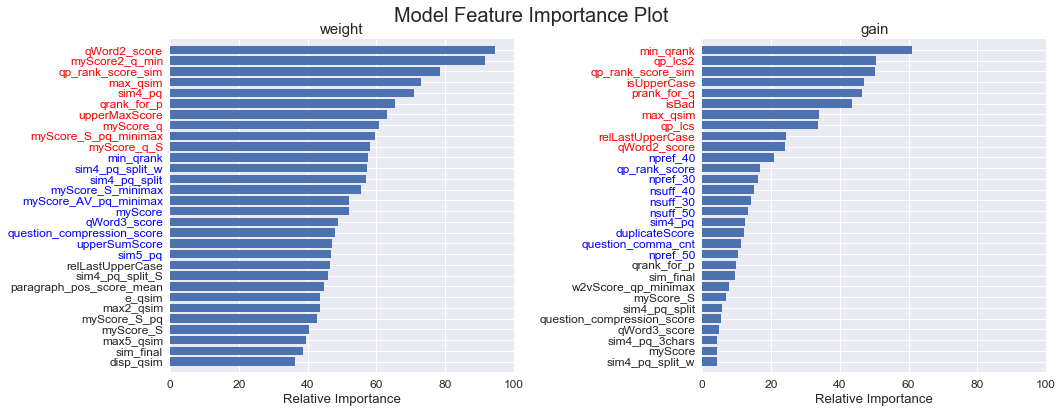

In [298]:
common_ml.drawFeaturesImportancePlot2(fi01['weight'], fi01['gain'], 30, names=['weight', 'gain'])

### Получение финальных предсказаний

In [300]:
final_columns = ['question_id', 'question', 'paragraph_id', 'paragraph', 'isTr', 'target', 'qCnt', 'p_target1', 'p_target01']
for suff in suff1:
    final_columns += ['p_isTrPred1' + suff, 'p_isTrPred01' + suff, 'p_target02' + suff]
final_df = dfp[final_columns].copy()

Преобразовываем предсказания:
* пары из тестовой выборки, у которых *qCnt* > 1: выход модели 2 делаем равным 1;
* пары из тестовой выборки, которые были "исправлены" при обучении второй модели: выход модели 2 делаем равным 1;
* пары из тренировочной выборки, для которых выход модели 2 не менее 0.95: выход модели 2 делаем равным 1;
* пары из тренировочной выборки, у которых *qCnt* > 1: выход модели 2 делаем равным 1;

In [301]:
final_df['p_isTrPred01_total'] = 0
final_df['p_isTrPred1_total'] = 0
for suff in suff1:
    final_df.loc[(final_df.qCnt > 1) & (final_df.isTr == 0), 'p_isTrPred01' + suff] = 1.0
    final_df.loc[(final_df['p_target02' + suff] == 1) & (final_df.isTr == 0), 'p_isTrPred01' + suff] = 1.0
    final_df.loc[(final_df['p_isTrPred01' + suff] >= 0.95) & (final_df.isTr == 1), 'p_isTrPred01' + suff] = 1.0
    final_df.loc[(final_df.qCnt > 1) & (final_df.isTr == 1), 'p_isTrPred01' + suff] = 1.0
    
    final_df['p_isTrPred01_total'] += final_df['p_isTrPred01' + suff] / 5
    final_df['p_isTrPred1_total'] += final_df['p_isTrPred1' + suff] / 5
    
    final_df['prediction_f' + suff] = final_df['p_isTrPred1' + suff] * final_df['p_isTrPred01' + suff]

In [302]:
final_df['prediction_f_total'] = (final_df['prediction_f_0'] + final_df['prediction_f_1'] + 
                                  final_df['prediction_f_2'] + final_df['prediction_f_3'] + \
                                  final_df['prediction_f_4']) / 5

Вычисляем ранги по всем парам (как из тренировочной, так и из тестовой выборки)

In [303]:
for suff in suff1:
    final_df['prediction_f_rank' + suff] = np.array(final_df['prediction_f' + suff]).argsort()[::-1].argsort()

In [304]:
final_df['final_rank'] = (final_df['prediction_f_rank_0'] + final_df['prediction_f_rank_1'] + 
                          final_df['prediction_f_rank_2'] + final_df['prediction_f_rank_3'] + \
                          final_df['prediction_f_rank_4']) / 5

In [305]:
final_df.loc[final_df.isTr == 0, 
             ['prediction_f_0', 'prediction_f_1', 'prediction_f_2', 'prediction_f_3', 'prediction_f_4', 'prediction_f_total',
              'prediction_f_rank_0', 'prediction_f_rank_1', 'prediction_f_rank_2', 'prediction_f_rank_3', 'prediction_f_rank_4',
             'final_rank']].\
    sort_values('final_rank', ascending=True).head(20)

,prediction_f_0,prediction_f_1,prediction_f_2,prediction_f_3,prediction_f_4,prediction_f_total,prediction_f_rank_0,prediction_f_rank_1,prediction_f_rank_2,prediction_f_rank_3,prediction_f_rank_4,final_rank
138439,0.990316,0.993558,0.991722,0.989995,0.984059,0.989930,148,50,91,167,493,189.8
177109,0.989296,0.983123,0.991359,0.993355,0.991868,0.989800,186,542,98,60,99,197.0
167725,0.988437,0.986184,0.983742,0.991663,0.989919,0.987989,233,326,500,110,160,265.8
166819,0.982513,0.984398,0.989311,0.990497,0.987820,0.986908,627,449,174,151,267,333.6
187749,0.986238,0.990812,0.983650,0.986338,0.981771,0.985762,359,127,507,365,675,406.6
189906,0.979212,0.990892,0.986990,0.979222,0.989438,0.985151,908,122,292,936,188,489.2
176864,0.988443,0.990401,0.971156,0.987096,0.995390,0.986497,232,145,1724,331,22,490.8
181036,0.983218,0.986318,0.980485,0.982655,0.980443,0.982624,565,313,734,636,795,608.6
141024,0.981140,0.988024,0.976535,0.979046,0.989152,0.982780,736,231,1121,951,202,648.2
187902,0.975413,0.987489,0.986260,0.977352,0.983087,0.981920,1311,255,337,1120,558,716.2


Оценим качество финального предсказания для тренировочной выборки

0.998540648524 0.998496829916 0.998548186128 0.998514667709 0.998512952646 
Усреднение предсказаний
0.998671786321
Усреднение рангов
0.998655811934


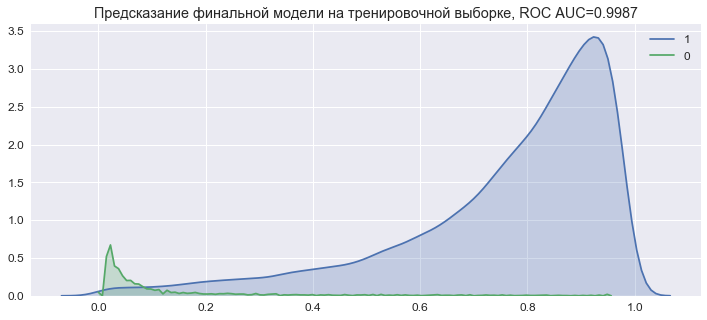

In [377]:
ind0 = (final_df.isTr == 1)
for suff in suff1:
    print(metrics.roc_auc_score(final_df[ind0].target, final_df[ind0]['prediction_f' + suff]), end = ' ')
print()
print('Усреднение предсказаний')
print(metrics.roc_auc_score(final_df[ind0].target, final_df[ind0].prediction_f_total))
print('Усреднение рангов')
tr_roc_auc = metrics.roc_auc_score(final_df[ind0].target, -final_df[ind0].final_rank)
print(tr_roc_auc)
plt.figure(figsize=(12, 5))
ax = sns.kdeplot(final_df[ind0][final_df[ind0].target == 1].prediction_f_total, shade=True, shade_lowest=False, label='1')
ax = sns.kdeplot(final_df[ind0][final_df[ind0].target == 0].prediction_f_total, shade=True, shade_lowest=False, label='0')
plt.title('Предсказание финальной модели на тренировочной выборке, ROC AUC={:.4f}'.format(tr_roc_auc))
plt.show()

Несмотря на то что для тренировочной выборки усреднение предсказаний дали немного лучший результат, по сравнению с усреднением рангов, в финальной посылки было выбрано именно усреднение рангов.

In [195]:
if not os.path.exists('submissions'):
    os.mkdir('submissions')

In [308]:
final_df['prediction'] = 1 - final_df['final_rank'] / 1000000.0
final_df[final_df.isTr == 0][['paragraph_id', 'question_id', 'prediction']].to_csv('submissions/winner_submission.csv', index = False)

In [309]:
print(metrics.roc_auc_score(final_df[ind0].target, final_df[ind0].prediction))

0.998655811934


**Вот так выглядят результаты на открытой и закрытой частях тестовой выборки**

<h4 align='center'>
Public & Private Leaderboards
<img src="img/pp_lb.png" width=1200px; height=600px>
</h4>

### Этап 6. Анализ предсказаний

**Распределение выходов моделей на тренировочной выборке**

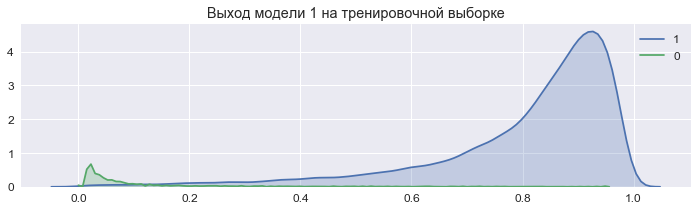

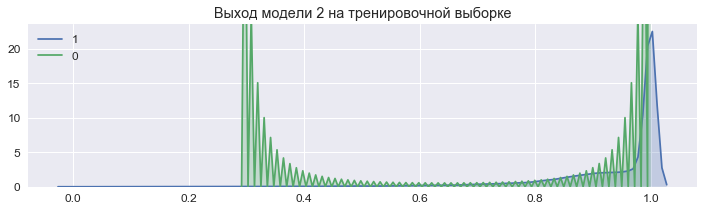

In [374]:
ind0 = (final_df.isTr == 1)
plt.figure(figsize=(12, 3))
sns.kdeplot(final_df[ind0 & (final_df.target == 1)].p_isTrPred1_total, shade=True, shade_lowest=False, label='1')
sns.kdeplot(final_df[ind0 & (final_df.target == 0)].p_isTrPred1_total, shade=True, shade_lowest=False, label='0')
plt.title('Выход модели 1 на тренировочной выборке')
plt.show()

ind0 = (final_df.isTr == 1)
plt.figure(figsize=(12, 3))
sns.kdeplot(final_df[ind0 & (final_df.target == 1)].p_isTrPred01_total, shade=True, shade_lowest=False, label='1')
sns.kdeplot(final_df[ind0 & (final_df.target == 0)].p_isTrPred01_total, shade=True, shade_lowest=False, label='0')
plt.title('Выход модели 2 на тренировочной выборке')
plt.show()

**Распределение выходов моделей на тестовой выборке**

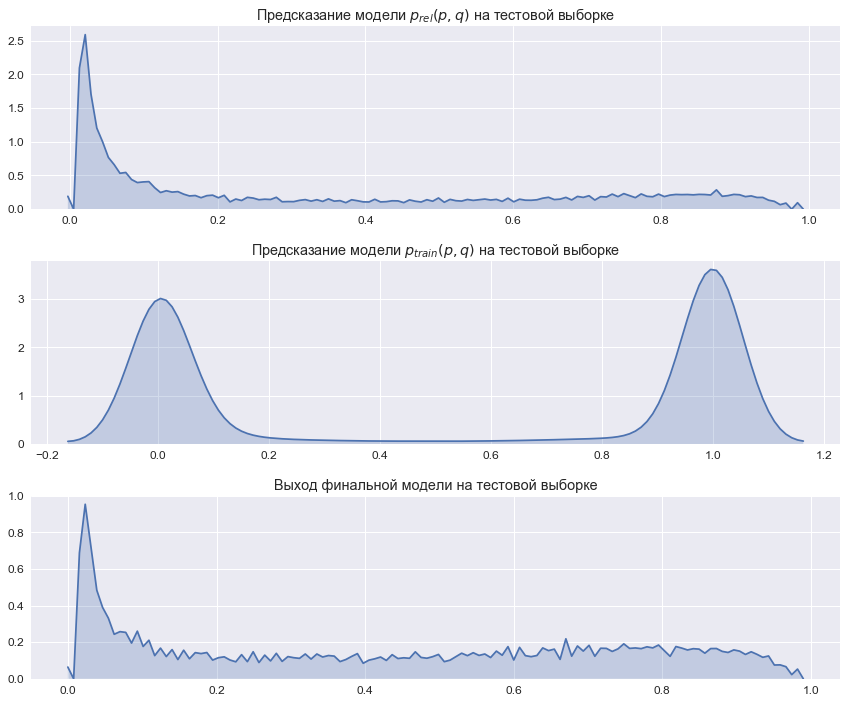

In [385]:
ind0 = (final_df.isTr == 0)
plt.figure(figsize=(12, 10))
plt.subplot(3, 1, 1)
ax = sns.kdeplot(final_df[ind0].p_isTrPred1_total, shade=True, shade_lowest=False, label='')
plt.title(r'Предсказание модели $p_{rel}(p, q)$ на тестовой выборке')

plt.subplot(3, 1, 2)
ax = sns.kdeplot(final_df[ind0].p_isTrPred01_total, shade=True, shade_lowest=False, label='')
plt.title(r'Предсказание модели $p_{train}(p, q)$ на тестовой выборке')

plt.subplot(3, 1, 3)
ax = sns.kdeplot(final_df[ind0].prediction_f_total, shade=True, shade_lowest=False, label='')
plt.title('Выход финальной модели на тестовой выборке')
plt.tight_layout()
plt.show()

**Распределение выходов обеих моделей**

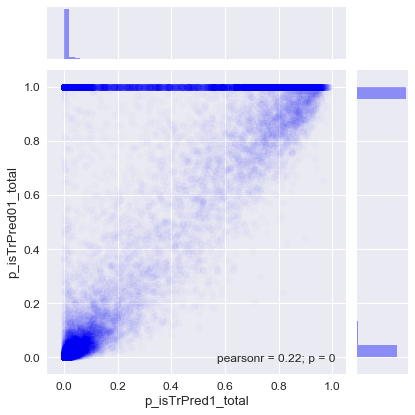

In [369]:
sns.jointplot(data=final_df[final_df.isTr == 0], x='p_isTrPred1_total', y='p_isTrPred01_total', color=[0, 0, 1, 0.01])

**Качественный анализ предсказаний и ошибок**

Посмотрим на топ-10 пар из тренировочной выборки с наиболее низким выходом второй модели (т.е. это пары, которые похожи на пары с синтетическим вопросом)

В этих парах вопросы уникальны в рамках предоставленных данных. Интересно, что все эти пары релевантные (вопрос релевантен параграфу), т.е. являются грубыми ошибками.

In [254]:
final_df.loc[(final_df.isTr == 1), ['paragraph', 'question', 'p_isTrPred01_total', 'p_isTrPred1_total', 'qCnt', 'target']].\
    sort_values('p_isTrPred01_total').head(10)

,paragraph,question,p_isTrPred01_total,p_isTrPred1_total,qCnt,target
103627,"В целях долгосрочного кредитования и субсидирования разных секторов экономики, включая мелкое предпринимательство и социальную сферу, правительством было создано шесть кредитно-финансовых институтов: Саудовский сельскохозяйственный банк, Саудовский фонд промышленного развития, Общественный инвестиционный фонд (Public Investment Fund), Риал Эстейт Девелопмент Бэнк (кредитование жилищного строительства) и Саудовский кредитный банк (нецелевое финансирование лиц с низким уровнем дохода). На 1986/87 финансовый год объем кредитов и финансирования, предоставленного этими учреждениями, составлял 166 402 млн. риялов, на 1991/92 финансовый год — 152 872 млн. риялов.",Когда показатель от шести кредитно-финансовых институтов сягнул отметки в 152 872 млн. риялов?,0.001220,0.005437,1,1.0
113582,"Престиж профессии дирижёра особенно вырос в начале XX века; широко распространившееся преклонение перед человеком, стоящим за пультом, дало повод Теодору Адорно написать: …общественный авторитет дирижёров в большинстве случаев намного превышает реальный вклад большинства из них в исполнение музыки . Те же соображения в 20-х годах вызвали к жизни попытки создать оркестры без дирижёра, и первый такой оркестр, Персимфанс, был создан в Москве в 1922 году. Однако идея себя не оправдала: как сам Персимфанс, так и другие оркестры, созданные по его образцу, оказались недолговечными.",Когда престиж профессии дирижёра особенно вырос?,0.019317,0.033250,1,1.0
119213,"Основные фонды относятся к производственным активам, так как создаются и используются в процессе производства. К основным фондам относятся объекты, которые служат не менее года и стоимостью выше определенной величины, устанавливаемой в зависимости от динамики цен на продукцию фондосоздающих отраслей (К основным фондам относятся объекты, стоимость которых определяется в размере пятидесятикратной установленной законом минимальной месячной. В качестве дополнительного критерия отнесения объекта к основным средствам выделяют стоимостной. Так, к основным средствам относят объекты, стоимость которых превышает 40 000 рублей.","Сколько должна быть минимальная цена объекта, чтобы именоваться производственным активом?",0.025155,0.138928,1,1.0
103441,"Человек обладает крайне развитым мозгом. Отношение массы мозга к массе тела больше, чем у многих других животных (за исключением, например, мелких птиц, коатов или паукообразных обезьян), а абсолютная масса мозга больше лишь у слонов и китообразных. Степень развития мозга может быть оценена, в частности, по соотношению массы спинного мозга к головному. Так, у кошек оно — 1:1, у собак — 1:3, у низших обезьян — 1:16, у человека — 1:50. У людей верхнего палеолита мозг был заметно (на 10—12 %) крупнее мозга современного человека.",Кто из представителей живой природы обладает крайне развитым мозгом?,0.025718,0.029827,1,1.0
112939,"Прогресс сенсибилизации фотоматериалов шёл поэтапно, начавшись с получения ортохроматических эмульсий Иосифом Эдером с помощью эритрозина. Полностью весь видимый спектр стал доступен для регистрации только после открытия Бенно Гомолкой сенсибилизатора пинацианола в 1906 году. Лишь после этого трехцветная фотография смогла полноценно отображать натуральные цвета объектов съёмки. Появились многочисленные конструкции цветных фотоаппаратов, осуществлявших цветоделение последовательной или одновременной съёмкой за разными светофильтрами. Наиболее популярный тип фотоаппаратов для последовательной съёмки на удлинённую панхроматическую фотопластинку сконструировал немецкий учёный Адольф Мите, а массовый выпуск наладил Вильгельм Бермполь. Камерой Бермполя-Мите русский фотограф Сергей Прокудин-Горский создал одну из наиболее масштабных во всём мире коллекций цветных фотографий.","Кто наладил массовый выпуск фотоаппаратов, предназначенных для последовательной съёмки на удлинённую панхроматическую фотопластинку?",0.029074,0.034695,1,1.0
9636,"Чешуекрылые широко распространены п

Всего в тренировочной выборке менее 7% пар, для которых предсказание модели 2 менее 0.9 (т.е. эти пары на 0.1 и более похожи на пары с синтетическим вопросом)

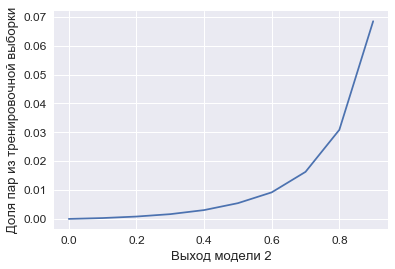

In [370]:
plt.figure(figsize=(6, 4))
plt.plot(np.linspace(0, 0.9, 10), [sum((final_df.isTr == 1) & (final_df.p_isTrPred01_total <= e)) for e in np.linspace(0, 0.9, 10)] / sum(final_df.isTr == 1))
plt.xlabel('Выход модели 2')
plt.ylabel('Доля пар из тренировочной выборки')
plt.show()

Посмотрим на топ-10 релевантных пар из тренировочной выборки с наиболее низким выходом первой модели (т.е. эти пары считаются явно НЕ релевантными, хотя таковыми не являются)

На вскидку, модель не находит некоторые синонимичные или сильно связанные пары слов, одно из слов которых находится в параграфе, а другое в вопросе:

* Л. Толстой - Лев Толстой
* Направился - двинулся
* женат - женитьба
* не входит - не относятся

Однако есть и гораздо менее понятные случаи

In [255]:
final_df.loc[(final_df.isTr == 1) & (final_df.target == 1), ['paragraph', 'question', 'p_isTrPred01_total', 'p_isTrPred1_total', 'qCnt', 'target']].\
    sort_values('p_isTrPred1_total').head(10)

,paragraph,question,p_isTrPred01_total,p_isTrPred1_total,qCnt,target
96443,"Крупные объекты — стационарные и полевые пункты дислокации войск, такие как общевойсковые, армейские, авиационные и военно-морские базы могут быть условно разделены на отдельные участки (site) по функциональному принципу для обслуживания их несколькими подрядчиками (к примеру, лётное поле, аэродром и ангары на условной авиабазе обслуживаются одним подрядчиком, топливозаправочный комплекс — другим, радиолокационные станции системы управления воздушным движением — третьим, радиолокационные станции системы раннего предупреждения — четвёртым, объекты электросети и энергоснабжения — пятым, объекты хозяйственно-бытовой инфраструктуры, водопроводной и канализационной системы — шестым, объекты питания, отдыха и расквартировки персонала — седьмым, и так далее). Крупные производственные объекты с многопрофильным производством и сложным производственным циклом, так же могут быть разбиты на участки по цеховому принципу, где конкретный подрядчик отвечает за выпуск того или иного вида продукции, или конкретный этап производственного цикла.",Что такое крупные объекты с государственной формой собственности?,1.00000,0.001410,3,1.0
80038,"В соответствии с классификацией Международной авиационной федерации выделяется семнадцать типов воздушных судов и иных летательных аппаратов[3]. Можно выделить восемь наиболее общих видов воздушных судов[6]: автожир, аэростат, вертолёт, винтокрыл, дирижабль, махолёт, планёр и самолёт. Основные различия между ними заключаются в удельном весе аппаратов, наличии и типе силовой установки и способе получения подъёмной силы. Также существуют и другие, гибридные летательные аппараты, объединяющие в себе свойства нескольких из указанных выше видов воздушных судов. К воздушным судам не относятся космические корабли, ракеты, экранопланы (но не экранолёты) и суда на воздушной подушке[источник не указан 686 дней].",Что не входит в этот перечень,1.00000,0.003006,3,1.0
56006,"Дагеротипия и калотипия использовались до второй половины XIX века, уступив место мокрому коллодионному процессу, соединившему преимущества негативно-позитивного метода Тальбота и высокого качества изображения. Появившаяся тогда же альбуминовая печать давала высококачественные бумажные отпечатки со стеклянных коллодионных негативов. Главным недостатком мокрого коллодия оказалась необходимость экспонирования и лабораторной обработки влажных фотопластинок в течение нескольких минут, пока светочувствительный слой остаётся проницаемым для обрабатывающих растворов. Проблема была решена только после изобретения английским врачом Ричардом Меддоксом в 1871 году желатиносеребряного процесса и так называемых сухих фотопластинок. Завершающей инновацией стала возможность использования в качестве подложки целлулоида вместо стекла, благодаря изобретению Ганнибалом Гудвином желатинового противоскручивающего контрслоя в 1887 году. Так место фотопластинок заняла фотоплёнка с желатиносеребряной эмульсией, доминирующая в аналоговой фотографии до сегодняшнего дня.",Что еще появилось в это же время?,1.00000,0.003020,6,1.0
118146,"Программным произведением русского витражного искусства, наиболее полно сконцентрировавшее в себе дух времени, стало художественное остекление Торгового дома братьев Елисеевых на Невском проспекте (сохранился лишь небольшой фрагмент). Многофигурная витражная композиция в огромном окне-экране главного фасада выражала идеи богатства страны, национальной самобытности и включенности России в общеевропейскую культуру. В конце девятнадцатого века Джон Ла Фарж и Луис Тиффани стали намеренно добиваться неоднородности стекла. Современное витражное стекло получается в результате использования множества разнообразнейших технологий. Стекло может быть прозрачным и глухим, однородного цвета и смесью различных цветов и оттенков одного цвета, гладким и с разнообразной фактурой.",Кто внес в русский витраж значительный вклад в 19-ом веке?,1.00000,0.003212,1,1.0
65420,"Культурные аспекты мог

~2500 релевантных пар тренировочной выборки, для которых выход модели 1 менее 0.5. (7% от числа всех релевантных пар)

In [275]:
ne = sum((final_df.isTr == 1) & (final_df.target == 1) & (final_df.p_isTrPred1_total < 0.5))
print(ne, ne / sum((final_df.isTr == 1) & (final_df.target == 1)))

2414 0.0709228192849


Посмотрим на топ-10 НЕрелевантных пар из тренировочной выборки с наиболее высоким выходом первой модели (т.е. эти пары считаются явно релевантными, хотя таковыми не являются)

Это пары, в которых вопрос сильно пересекается по словам с параграфом, однако вопрос вероятно, задан к похожему параграфу из этой же тематики.

In [256]:
final_df.loc[(final_df.isTr == 1) & (final_df.target == 0), ['paragraph', 'question', 'p_isTrPred01_total', 'p_isTrPred1_total', 'qCnt', 'target']].\
    sort_values('p_isTrPred1_total', ascending=False).head(10)

,paragraph,question,p_isTrPred01_total,p_isTrPred1_total,qCnt,target
83215,"Аравийский полуостров расположен на северо-восточной части древней Африкано-Аравийской платформы. На западе и в центре полуострова на поверхность выходят метаморфические и кристаллические породы протерозоя Нубийско-Аравийского щита, на юго-западе — породы Аравийско-Аденско-Сомалийского щита. Осевые части щитов рассекаются молодыми грабенами Аденского залива и Красного моря. Южная и западная части полуострова неоднократно подвергались активизации начиная с конца мелового периода. Вдоль сбросовых уступов к Красному морю возникли вулканические конусы, а по линиям молодых разломов произошли излияния базальтов. Сложенные кристаллическими и метаморфическими породами щиты подверглись длительной денудации, в результате чего образовался рельеф поднятых до 1800—2300 м цокольных плоскогорий и плато. Восточная часть полуострова является плитой платформы, в которой породы фундамента погружаются под осадочный чехол главным образом меловых, юрских и кайнозойских песчаников и известняков. В восточной части Аравийского полуострова расположена историческая область Эль-Хаса с отметками высот менее 200 метров.",Какая растительность расположена выше отметки в 1800 метров на Аравийском полуострове?,1.000000,0.962470,2,0.0
103254,"В 1040 году в Поморавье вспыхнуло антивизантийское восстание под предводительством Петра Деляна. Среди захваченных восставшими городов был и Белград, где Делян объявил себя внуком болгарского царя Самуила и был провозглашен болгарским царем под именем Петра II. В 1041 году восстание было подавлено византийцами. На протяжении Xi—XII вв. город был ареной ожесточенной борьбы между Византией и Венгрией. Кроме армий этих держав его несколько раз опустошали крестоносцы, шедшие через этот район в Палестину.",Под каким именем изначально был основан Белград?,1.000000,0.950410,3,0.0
105631,"Руководители высшего звена отвечают за принятие стратегически важнейших решений для организации в целом или для основной части организации. Если высшее руководство фирмы решает перевести корпорацию на выпуск продукции, которая не в состоянии бороться с конкуренцией, то руководители среднего и низового звеньев мало что могут сделать, чтобы препятствовать крупному провалу. Сильные руководители высшего звена накладывают отпечаток своей личности на весь облик компании. Поэтому успешно действующие руководители высшего звена в больших организациях ценятся очень высоко, и их труд оплачивается очень хорошо.",Что испытывало руководство среднего звена,1.000000,0.947084,1,0.0
115555,"Всплески происходят в диапазоне частот от 5 до 43 МГц (чаще всего около 18 МГц), в среднем их ширина составляет примерно 1 МГц. Длительность всплеска невелика: от 0,1—1 с (иногда до 15 с). Излучение сильно поляризовано, особенно по кругу, степень поляризации достигает 100 %. Наблюдается модуляция излучения близким спутником Юпитера Ио, вращающимся внутри магнитосферы: вероятность появления всплеска больше, когда Ио находится вблизи элонгации по отношению к Юпитеру. Монохроматический характер излучения говорит о выделенной частоте, скорее всего гирочастоте. Высокая яркостная температура (иногда достигает 1015 K) требует привлечения коллективных эффектов (типа мазеров).",Выше ли яркостная температура чем равносильная Юпитера?,1.000000,0.939876,1,0.0
93133,"В 792 году сын Карла от его первой жены Химильтруды Пипин, прозванный Горбатым, узнав, что он отстранён от наследования, поднял восстание. Он сумел увлечь за собой несколько графств, но потерпел поражение. Весь год Карл провёл в Регенсбурге, но от нового похода против авар его отвлекло восстание саксов. Размах его превзошёл даже события 785 года. К саксам присоединились фризы и славяне. Повсюду были разрушены храмы и перебиты франкские гарнизоны. Летом 794 года Карл и его сын Карл Юный во главе двух армий вторглись в Саксонию. Видя себя окруженными, саксы массами бросились к Эресбургу, принесли клятвы верности, дали заложников и вернулись к христианству

~240 НЕрелевантных пар тренировочной выборки, для которых выход модели 1 более 0.5. (0.3% от числа всех НЕрелевантных пар)

In [278]:
ne = sum((final_df.isTr == 1) & (final_df.target == 0) & (final_df.p_isTrPred1_total > 0.5))
print(ne, ne / sum((final_df.isTr == 1) & (final_df.target == 0)))

238 0.00278815852673
